# Setup

## Load code and data

In [1]:
## import code
# basics and plotting
import re
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

# cross validation and modeling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_predict

# tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import validation_curve

# staticial comparison of model performance
# see https://github.com/janezd/baycomp
# to install library:
# pip install baycomp
from baycomp.single import two_on_single

# feature importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# stats
import scipy.stats as stats

In [2]:
# load preprocessed data set into a dataframe
data = pd.read_csv('data_preproc.csv')

# Hypothesis 1

## nssi_bin

In [29]:
# define target
target = data['nssi_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [30]:
# always predict most frequent target class
dummy_results = cross_validate(DummyClassifier(), features, target, 
                               scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)
print('The mean accuracy with cross-validation is: ' 
      f'{dummy_results["test_accuracy"].mean():.3f} +/- {dummy_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{dummy_results["test_precision"].mean():.3f} +/- {dummy_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{dummy_results["test_recall"].mean():.3f} +/- {dummy_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.674 +/- 0.002
The mean precision with cross-validation is: 0.674 +/- 0.002
The mean recall with cross-validation is: 1.000 +/- 0.000
The mean AUROC with cross-validation is: 0.500 +/- 0.000


### Logistic regression model

In [31]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [32]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [33]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'logisticregression__C': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [34]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'logisticregression__C': 0.1}
with AUROC of 0.759
Best hyperparameters for split #2:
{'logisticregression__C': 0.1}
with AUROC of 0.743
Best hyperparameters for split #3:
{'logisticregression__C': 0.1}
with AUROC of 0.744
Best hyperparameters for split #4:
{'logisticregression__C': 0.1}
with AUROC of 0.750
Best hyperparameters for split #5:
{'logisticregression__C': 0.1}
with AUROC of 0.765


0.1 appears best for C, but let's zoom in with a validation curve

In [35]:
# generate validation curve for C
C_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1, 2]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=-1)

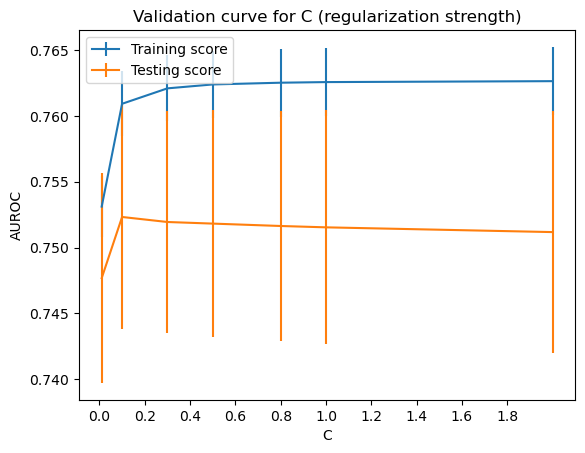

In [36]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 2, 0.2))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

In [37]:
# generate validation curve for C
C_values = [0.005, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=-1)

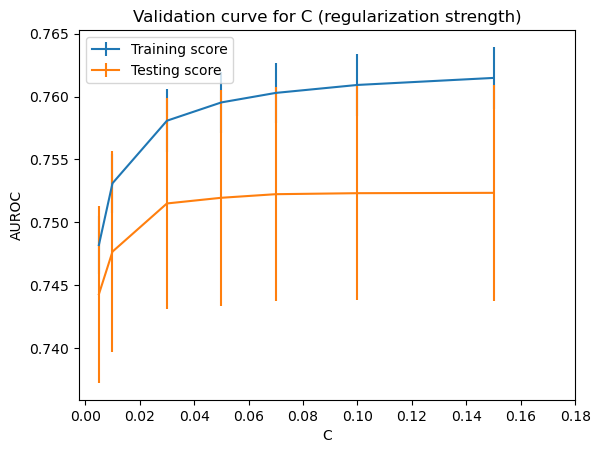

In [38]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.2, 0.02))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

0.1 appears sufficient for C.

In [39]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.690 +/- 0.030
The mean precision with cross-validation is: 0.822 +/- 0.025
The mean recall with cross-validation is: 0.690 +/- 0.035
The mean AUROC with cross-validation is: 0.750 +/- 0.033


### Random forest model

In [40]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [41]:
# define algorithm
rfc = RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced')

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfc)

In [42]:
# hyperparameter values to try
param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [43]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.1}
with AUROC of 0.734
Best hyperparameters for split #2:
{'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.1}
with AUROC of 0.725
Best hyperparameters for split #3:
{'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.1}
with AUROC of 0.730
Best hyperparameters for split #4:
{'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.1}
with AUROC of 0.738
Best hyperparameters for split #5:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 32, 'randomforestclassifier__max_features': 0.1}
with AUROC of 0.750


200 appears sufficient for n_estimators. Let's zoom in around max_leaf_nodes of 64 and max_features of 0.1

In [44]:
pipeline.set_params(randomforestclassifier__n_estimators=200)
pipeline.set_params(randomforestclassifier__max_features=0.1)

# first generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=-1)

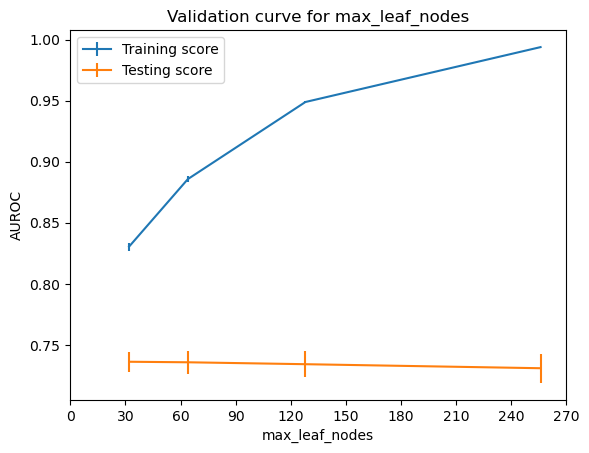

In [45]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 300, 30))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

In [46]:
pipeline.set_params(randomforestclassifier__max_features=0.2)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=-1)

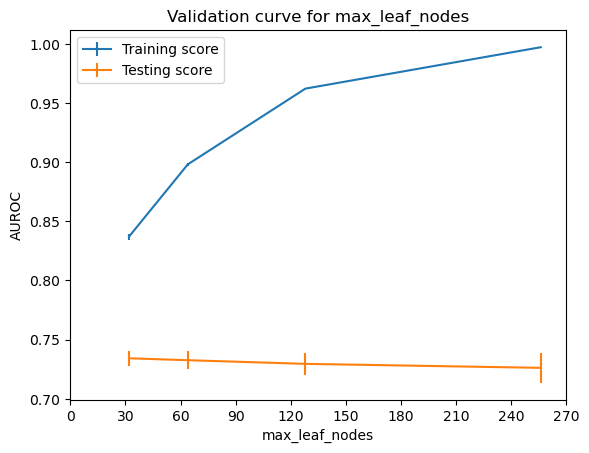

In [47]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 300, 30))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

In [48]:
pipeline.set_params(randomforestclassifier__max_features=0.3)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=-1)

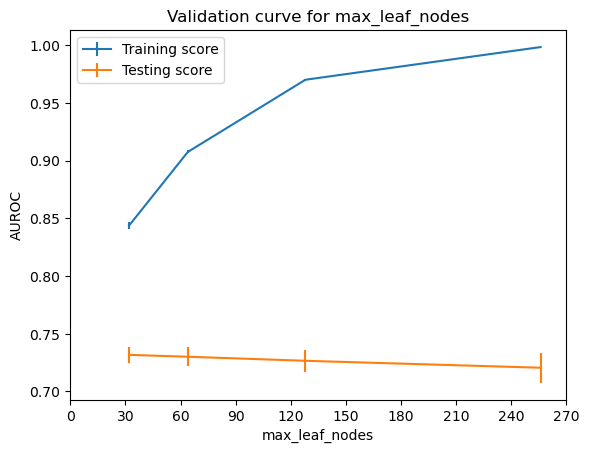

In [49]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 300, 30))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 32 and max_features of 0.1 appears sufficient.

In [50]:
pipeline.set_params(randomforestclassifier__max_features=0.1)
pipeline.set_params(randomforestclassifier__max_leaf_nodes=32)

# get results from tuned model
rfc_results = cross_validate(pipeline, features, target, 
                             scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_accuracy"].mean():.3f} +/- {rfc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{rfc_results["test_precision"].mean():.3f} +/- {rfc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{rfc_results["test_recall"].mean():.3f} +/- {rfc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.690 +/- 0.032
The mean precision with cross-validation is: 0.798 +/- 0.025
The mean recall with cross-validation is: 0.724 +/- 0.036
The mean AUROC with cross-validation is: 0.737 +/- 0.035


### Gradient boosting decision trees model

In [51]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [52]:
# hyperparameter tuning

# have to manually adjust weights to correct for class imbalance
# since HistGradientBoostingClassifier doesn't have a built-in class_weight parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=target)

# define algorithm
hgbc = HistGradientBoostingClassifier(random_state=0, categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbc)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingclassifier__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [53]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.736
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.723
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.718
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.724
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.757


Let's examine max_leaf_nodes while holding max_iter at 50.

In [54]:
pipeline.set_params(histgradientboostingclassifier__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 12, 16, 20, 24]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=-1)

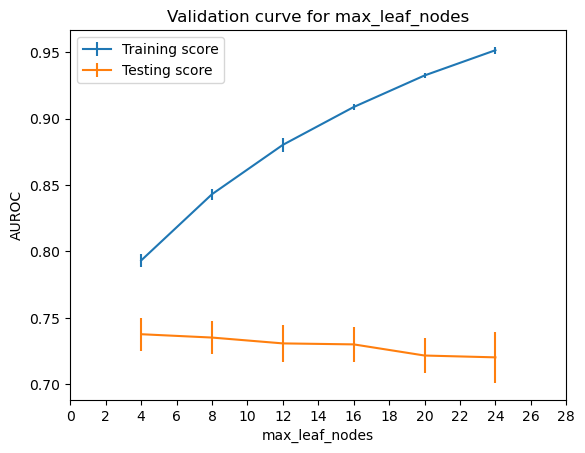

In [55]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 30, 2))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [56]:
pipeline.set_params(histgradientboostingclassifier__max_leaf_nodes=4)

# get results from tuned model
hgbc_results = cross_validate(pipeline, features, target, 
                              scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val, 
                              fit_params={'histgradientboostingclassifier__sample_weight': sample_weights})

print('The mean accuracy with cross-validation is: ' 
      f'{hgbc_results["test_accuracy"].mean():.3f} +/- {hgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{hgbc_results["test_precision"].mean():.3f} +/- {hgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{hgbc_results["test_recall"].mean():.3f} +/- {hgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.686 +/- 0.030
The mean precision with cross-validation is: 0.809 +/- 0.024
The mean recall with cross-validation is: 0.699 +/- 0.035
The mean AUROC with cross-validation is: 0.740 +/- 0.033


### Model comparison

In [57]:
print('Dummy baseline model')
print('AUROC: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 
print()
print('Logistic regression model')
print('AUROC: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 
print()
print('Random forest model')
print('AUROC: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 
print()
print('Gradient boosting decision trees model')
print('AUROC: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

Dummy baseline model
AUROC: 0.500 +/- 0.000

Logistic regression model
AUROC: 0.750 +/- 0.033

Random forest model
AUROC: 0.737 +/- 0.035

Gradient boosting decision trees model
AUROC: 0.740 +/- 0.033


((0.7424942062024524, 0.2575006346534301, 5.159144117472536e-06), <Figure size 640x480 with 1 Axes>)


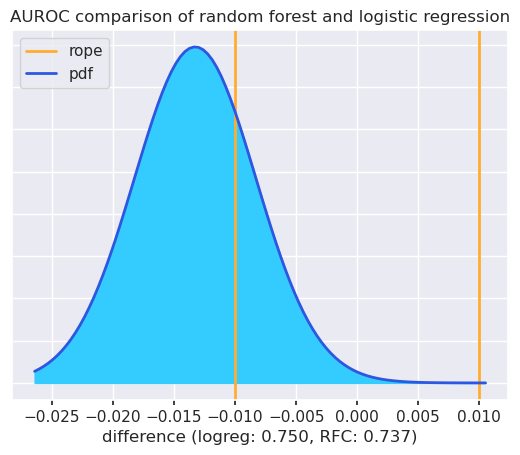

In [58]:
# statistical test comparing performance
rfc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=rfc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'RFC'), plot=True)
plt.title("AUROC comparison of random forest and logistic regression")
print(rfc_vs_logreg)

((0.4885078041198958, 0.5114921607490786, 3.513102564411952e-08), <Figure size 640x480 with 1 Axes>)


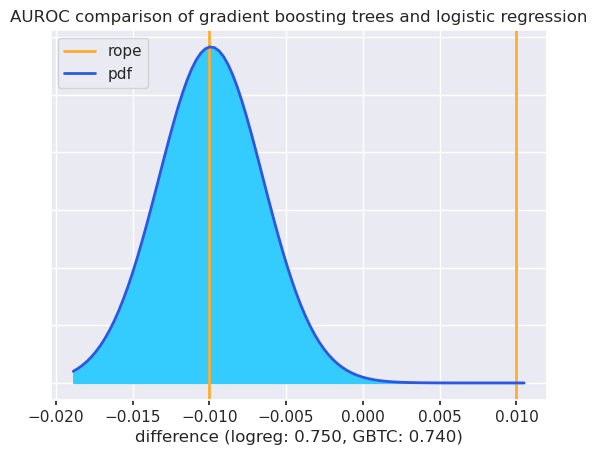

In [59]:
# statistical test comparing performance
hgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=hgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'GBTC'), plot=True)
plt.title("AUROC comparison of gradient boosting trees and logistic regression")
print(hgbc_vs_logreg)

((3.188323265757753e-41, 0.0, 1.0), <Figure size 640x480 with 1 Axes>)


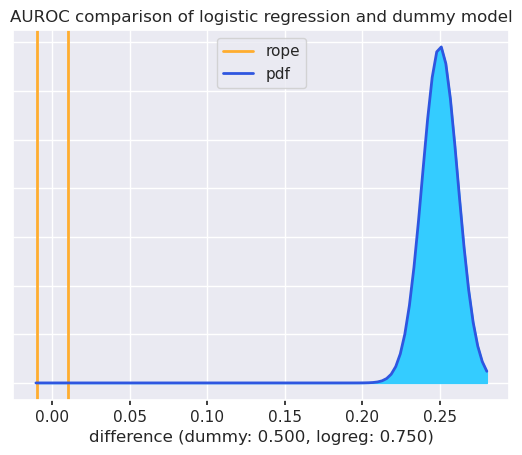

In [60]:
# statistical test comparing performance
logreg_vs_dummy = two_on_single(x=dummy_results["test_roc_auc"], y=logreg_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('dummy', 'logreg'), plot=True)
plt.title("AUROC comparison of logistic regression and dummy model")
print(logreg_vs_dummy)

## si_bin

In [61]:
# define target
target = data['si_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [62]:
# always predict most frequent target class
dummy_results = cross_validate(DummyClassifier(), features, target, 
                               scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)
print('The mean accuracy with cross-validation is: ' 
      f'{dummy_results["test_accuracy"].mean():.3f} +/- {dummy_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{dummy_results["test_precision"].mean():.3f} +/- {dummy_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{dummy_results["test_recall"].mean():.3f} +/- {dummy_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.812 +/- 0.001
The mean precision with cross-validation is: 0.812 +/- 0.001
The mean recall with cross-validation is: 1.000 +/- 0.000
The mean AUROC with cross-validation is: 0.500 +/- 0.000


### Logistic regression model

In [63]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [64]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [65]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'logisticregression__C': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [66]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'logisticregression__C': 0.1}
with AUROC of 0.716
Best hyperparameters for split #2:
{'logisticregression__C': 0.1}
with AUROC of 0.759
Best hyperparameters for split #3:
{'logisticregression__C': 0.1}
with AUROC of 0.782
Best hyperparameters for split #4:
{'logisticregression__C': 0.1}
with AUROC of 0.748
Best hyperparameters for split #5:
{'logisticregression__C': 0.1}
with AUROC of 0.749


0.1 appears best for C, but let's zoom in with a validation curve

In [67]:
# generate validation curve for C
C_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1, 2]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=-1)

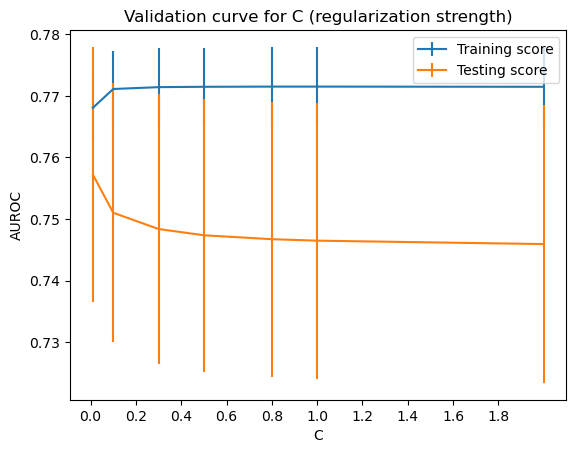

In [68]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 2, 0.2))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

A value less than 0.1 for C may be better.

In [69]:
# generate validation curve for C
C_values = [0.005, 0.01, 0.03, 0.05, 0.07, 0.09]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=-1)

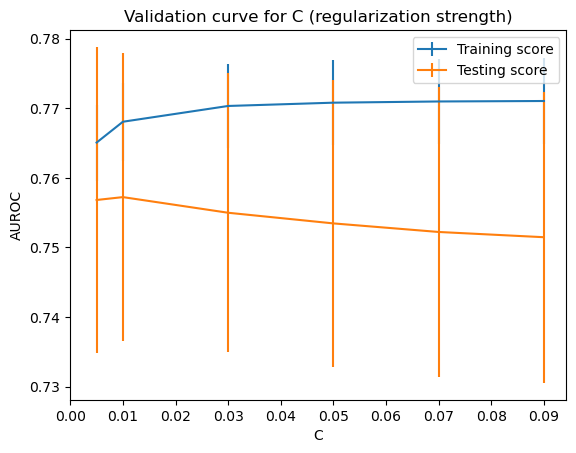

In [70]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.1, 0.01))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

C of 0.01 appears best.

In [71]:
pipeline.set_params(logisticregression__C=0.01)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.707 +/- 0.026
The mean precision with cross-validation is: 0.913 +/- 0.020
The mean recall with cross-validation is: 0.707 +/- 0.030
The mean AUROC with cross-validation is: 0.759 +/- 0.040


### Random forest model

In [72]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [73]:
# define algorithm
rfc = RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced')

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfc)

In [74]:
# hyperparameter values to try
param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [75]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.3}
with AUROC of 0.712
Best hyperparameters for split #2:
{'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.1}
with AUROC of 0.757
Best hyperparameters for split #3:
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.2}
with AUROC of 0.808
Best hyperparameters for split #4:
{'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.2}
with AUROC of 0.750
Best hyperparameters for split #5:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.2}
with AUROC of 0.797


We'll try a more focused search around these results.

In [76]:
pipeline.set_params(randomforestclassifier__n_estimators=200)

param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [77]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_leaf_nodes': 128}
with AUROC of 0.712
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__max_leaf_nodes': 128}
with AUROC of 0.754
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__max_leaf_nodes': 64}
with AUROC of 0.810
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__max_leaf_nodes': 128}
with AUROC of 0.755
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__max_leaf_nodes': 64}
with AUROC of 0.797


In [78]:
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)

param_grid =  {
    'randomforestclassifier__n_estimators': [100, 200, 300, 400],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [79]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 300}
with AUROC of 0.704
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__n_estimators': 400}
with AUROC of 0.754
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__n_estimators': 100}
with AUROC of 0.808
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__n_estimators': 400}
with AUROC of 0.751
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__n_estimators': 200}
with AUROC of 0.797


In [80]:
pipeline.set_params(randomforestclassifier__max_features=0.2)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__n_estimators', 
    param_range=n_estimators_values, scoring='roc_auc', n_jobs=-1)

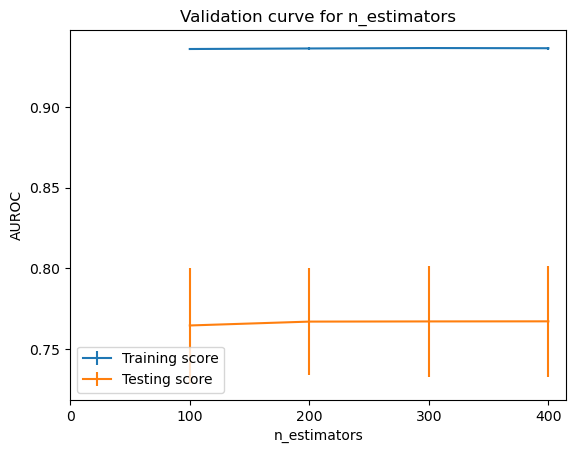

In [81]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 500, 100))
plt.xlabel("n_estimators")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for n_estimators")

In [82]:
pipeline.set_params(randomforestclassifier__n_estimators=200)

# generate validation curve for max_features
max_features_values = [0.1, 0.2, 0.3, 0.4]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_features', 
    param_range=max_features_values, scoring='roc_auc', n_jobs=-1)

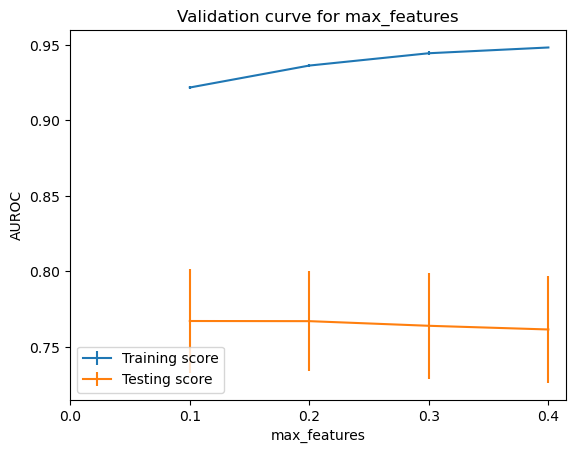

In [83]:
# plot validation curve for max_features
plt.errorbar(max_features_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_features_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.5, 0.1))
plt.xlabel("max_features")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_features")

We will proceed with max_leaf_nodes of 64, n_estimators of 200, and max_features of 0.2.

In [84]:
pipeline.set_params(randomforestclassifier__max_features=0.2)
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)
pipeline.set_params(randomforestclassifier__n_estimators=200)

# get results from tuned model
rfc_results = cross_validate(pipeline, features, target, 
                             scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_accuracy"].mean():.3f} +/- {rfc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{rfc_results["test_precision"].mean():.3f} +/- {rfc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{rfc_results["test_recall"].mean():.3f} +/- {rfc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.783 +/- 0.021
The mean precision with cross-validation is: 0.888 +/- 0.016
The mean recall with cross-validation is: 0.839 +/- 0.026
The mean AUROC with cross-validation is: 0.767 +/- 0.040


### Gradient boosting decision trees model

In [85]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [86]:
# hyperparameter tuning

# have to manually adjust weights to correct for class imbalance
# since HistGradientBoostingClassifier doesn't have a built-in class_weight parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=target)

# define algorithm
hgbc = HistGradientBoostingClassifier(random_state=0, categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbc)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingclassifier__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [87]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.708
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.765
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.796
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.760
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.755


Let's examine max_leaf_nodes while holding max_iter at 50.

In [88]:
pipeline.set_params(histgradientboostingclassifier__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 12, 16, 20, 24]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=-1)

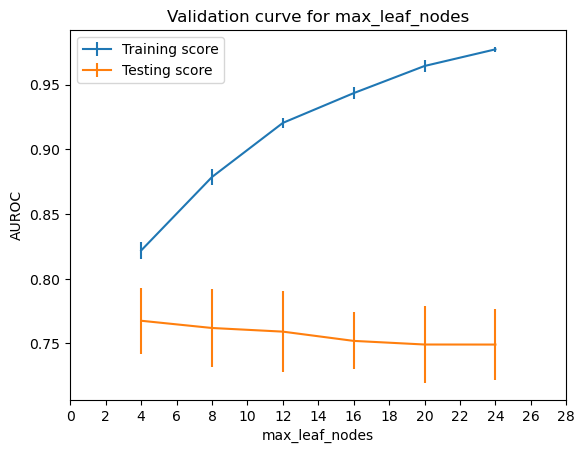

In [89]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 30, 2))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [90]:
pipeline.set_params(histgradientboostingclassifier__max_leaf_nodes=4)

# get results from tuned model
hgbc_results = cross_validate(pipeline, features, target, 
                              scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val, 
                              fit_params={'histgradientboostingclassifier__sample_weight': sample_weights})

print('The mean accuracy with cross-validation is: ' 
      f'{hgbc_results["test_accuracy"].mean():.3f} +/- {hgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{hgbc_results["test_precision"].mean():.3f} +/- {hgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{hgbc_results["test_recall"].mean():.3f} +/- {hgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.730 +/- 0.025
The mean precision with cross-validation is: 0.906 +/- 0.019
The mean recall with cross-validation is: 0.746 +/- 0.031
The mean AUROC with cross-validation is: 0.768 +/- 0.037


### Model comparison

In [91]:
print('Dummy baseline model')
print('AUROC: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 
print()
print('Logistic regression model')
print('AUROC: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 
print()
print('Random forest model')
print('AUROC: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 
print()
print('Gradient boosting decision trees model')
print('AUROC: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

Dummy baseline model
AUROC: 0.500 +/- 0.000

Logistic regression model
AUROC: 0.759 +/- 0.040

Random forest model
AUROC: 0.767 +/- 0.040

Gradient boosting decision trees model
AUROC: 0.768 +/- 0.037


((0.0012048446945662054, 0.6646748136394708, 0.33412034166596305), <Figure size 640x480 with 1 Axes>)


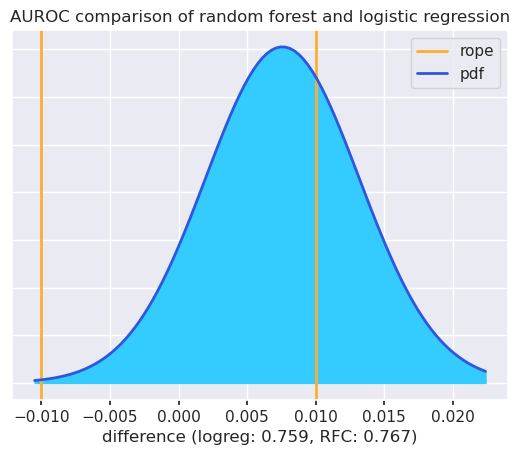

In [92]:
# statistical test comparing performance
rfc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=rfc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'RFC'), plot=True)
plt.title("AUROC comparison of random forest and logistic regression")
print(rfc_vs_logreg)

((0.0012186217721926239, 0.5474348675687077, 0.4513465106590996), <Figure size 640x480 with 1 Axes>)


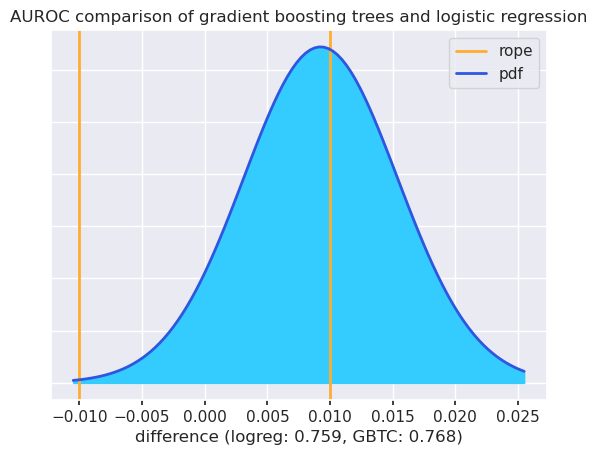

In [93]:
# statistical test comparing performance
hgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=hgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'GBTC'), plot=True)
plt.title("AUROC comparison of gradient boosting trees and logistic regression")
print(hgbc_vs_logreg)

((3.733269034289169e-35, 0.0, 1.0), <Figure size 640x480 with 1 Axes>)


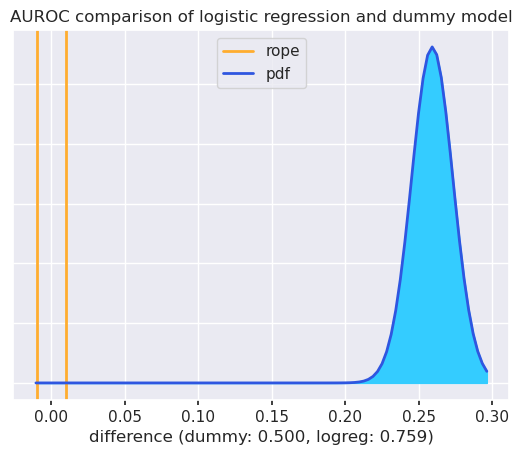

In [94]:
# statistical test comparing performance
logreg_vs_dummy = two_on_single(x=dummy_results["test_roc_auc"], y=logreg_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('dummy', 'logreg'), plot=True)
plt.title("AUROC comparison of logistic regression and dummy model")
print(logreg_vs_dummy)

## attempt_bin

In [95]:
# define target
target = data['attempt_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [96]:
# always predict most frequent target class
dummy_results = cross_validate(DummyClassifier(), features, target, 
                               scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)
print('The mean accuracy with cross-validation is: ' 
      f'{dummy_results["test_accuracy"].mean():.3f} +/- {dummy_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{dummy_results["test_precision"].mean():.3f} +/- {dummy_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{dummy_results["test_recall"].mean():.3f} +/- {dummy_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 

C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precis

The mean accuracy with cross-validation is: 0.681 +/- 0.002
The mean precision with cross-validation is: 0.000 +/- 0.000
The mean recall with cross-validation is: 0.000 +/- 0.000
The mean AUROC with cross-validation is: 0.500 +/- 0.000


C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Warning is expected. It means precision can't really be defined 
because the positive class is never predicted (because it is the minority class in this case).

### Logistic regression model

In [97]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [98]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [99]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'logisticregression__C': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [100]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'logisticregression__C': 0.1}
with AUROC of 0.738
Best hyperparameters for split #2:
{'logisticregression__C': 0.1}
with AUROC of 0.773
Best hyperparameters for split #3:
{'logisticregression__C': 0.1}
with AUROC of 0.803
Best hyperparameters for split #4:
{'logisticregression__C': 0.1}
with AUROC of 0.752
Best hyperparameters for split #5:
{'logisticregression__C': 0.1}
with AUROC of 0.737


0.1 appears best for C, but let's zoom in with a validation curve

In [101]:
# generate validation curve for C
C_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1, 2]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=-1)

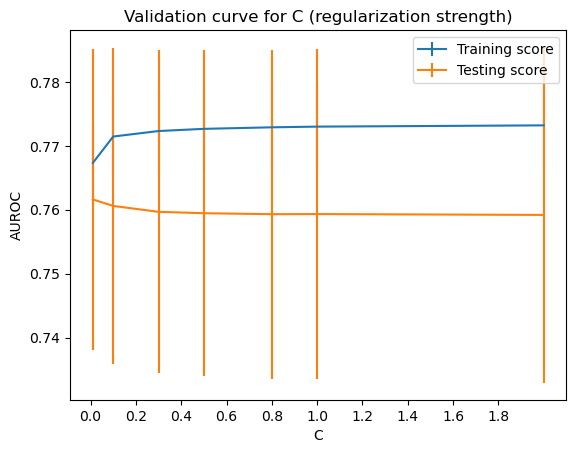

In [102]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 2, 0.2))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

A value less than 0.1 for C may be better.

In [103]:
# generate validation curve for C
C_values = [0.005, 0.01, 0.03, 0.05, 0.07, 0.09]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=-1)

In [104]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.1, 0.01))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

C of 0.01 appears best.

In [105]:
pipeline.set_params(logisticregression__C=0.01)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.697 +/- 0.024
The mean precision with cross-validation is: 0.520 +/- 0.029
The mean recall with cross-validation is: 0.705 +/- 0.044
The mean AUROC with cross-validation is: 0.762 +/- 0.028


### Random forest model

In [106]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [107]:
# define algorithm
rfc = RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced')

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfc)

In [108]:
# hyperparameter values to try
param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [109]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.2}
with AUROC of 0.729
Best hyperparameters for split #2:
{'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.1}
with AUROC of 0.776
Best hyperparameters for split #3:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.3}
with AUROC of 0.799
Best hyperparameters for split #4:
{'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.3}
with AUROC of 0.748
Best hyperparameters for split #5:
{'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__max_leaf_nodes': 32, 'randomforestclassifier__max_features': 0.3}
with AUROC of 0.737


We'll try a more focused search around these results.

In [110]:
pipeline.set_params(randomforestclassifier__n_estimators=200)

param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [111]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__max_leaf_nodes': 32}
with AUROC of 0.729
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__max_leaf_nodes': 32}
with AUROC of 0.772
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_leaf_nodes': 64}
with AUROC of 0.799
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_leaf_nodes': 32}
with AUROC of 0.749
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.4, 'randomforestclassifier__max_leaf_nodes': 32}
with AUROC of 0.732


In [112]:
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)

param_grid =  {
    'randomforestclassifier__n_estimators': [100, 200, 300, 400],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [113]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__n_estimators': 400}
with AUROC of 0.727
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__n_estimators': 400}
with AUROC of 0.773
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 200}
with AUROC of 0.799
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 100}
with AUROC of 0.747
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 400}
with AUROC of 0.739


In [114]:
pipeline.set_params(randomforestclassifier__max_features=0.3)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__n_estimators', 
    param_range=n_estimators_values, scoring='roc_auc', n_jobs=-1)

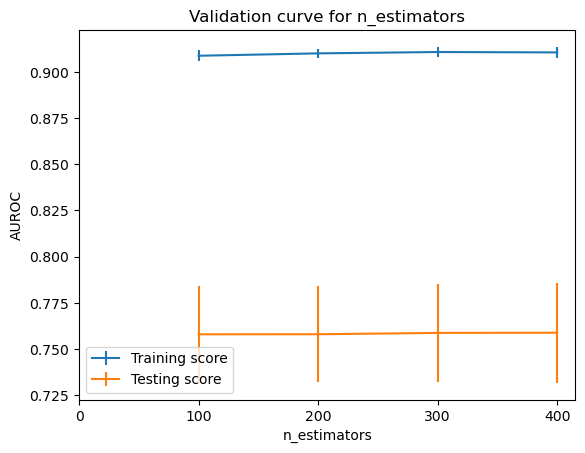

In [115]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 500, 100))
plt.xlabel("n_estimators")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for n_estimators")

In [116]:
pipeline.set_params(randomforestclassifier__n_estimators=300)

# generate validation curve for max_features
max_features_values = [0.1, 0.2, 0.3, 0.4]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_features', 
    param_range=max_features_values, scoring='roc_auc', n_jobs=-1)

In [117]:
# plot validation curve for max_features
plt.errorbar(max_features_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_features_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.5, 0.1))
plt.xlabel("max_features")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_features")

In [118]:
pipeline.set_params(randomforestclassifier__max_features=0.4)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [16, 32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=-1)

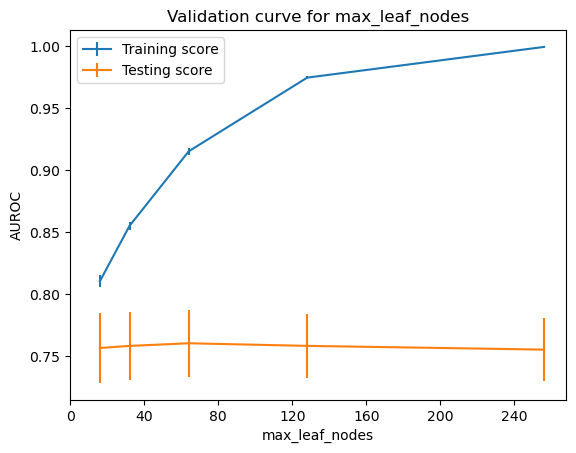

In [119]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 280, 40))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

We will proceed with max_leaf_nodes of 64, n_estimators of 300, and max_features of 0.4.

In [120]:
pipeline.set_params(randomforestclassifier__max_features=0.4)
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)
pipeline.set_params(randomforestclassifier__n_estimators=300)

# get results from tuned model
rfc_results = cross_validate(pipeline, features, target, 
                             scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_accuracy"].mean():.3f} +/- {rfc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{rfc_results["test_precision"].mean():.3f} +/- {rfc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{rfc_results["test_recall"].mean():.3f} +/- {rfc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.715 +/- 0.022
The mean precision with cross-validation is: 0.550 +/- 0.032
The mean recall with cross-validation is: 0.604 +/- 0.051
The mean AUROC with cross-validation is: 0.754 +/- 0.027


### Gradient boosting decision trees model

In [121]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [122]:
# hyperparameter tuning

# have to manually adjust weights to correct for class imbalance
# since HistGradientBoostingClassifier doesn't have a built-in class_weight parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=target)

# define algorithm
hgbc = HistGradientBoostingClassifier(random_state=0, categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbc)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingclassifier__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [123]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.729
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.765
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.804
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.744
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with AUROC of 0.731


Let's examine max_leaf_nodes while holding max_iter at 50.

In [124]:
pipeline.set_params(histgradientboostingclassifier__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 12, 16, 20, 24]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=-1)

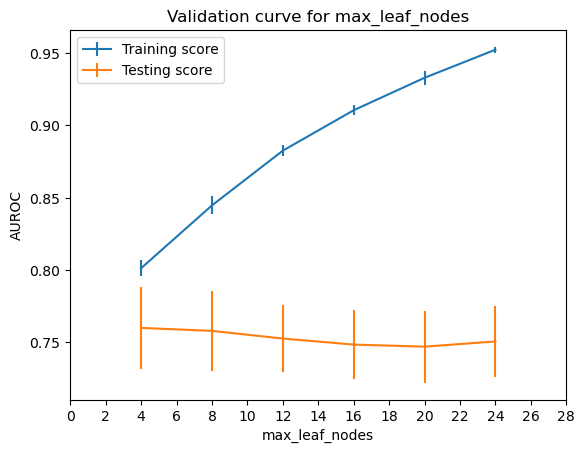

In [125]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 30, 2))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [126]:
pipeline.set_params(histgradientboostingclassifier__max_leaf_nodes=4)

# get results from tuned model
hgbc_results = cross_validate(pipeline, features, target, 
                              scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val, 
                              fit_params={'histgradientboostingclassifier__sample_weight': sample_weights})

print('The mean accuracy with cross-validation is: ' 
      f'{hgbc_results["test_accuracy"].mean():.3f} +/- {hgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{hgbc_results["test_precision"].mean():.3f} +/- {hgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{hgbc_results["test_recall"].mean():.3f} +/- {hgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.695 +/- 0.027
The mean precision with cross-validation is: 0.518 +/- 0.033
The mean recall with cross-validation is: 0.686 +/- 0.049
The mean AUROC with cross-validation is: 0.759 +/- 0.027


### Model comparison

In [127]:
print('Dummy baseline model')
print('AUROC: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 
print()
print('Logistic regression model')
print('AUROC: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 
print()
print('Random forest model')
print('AUROC: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 
print()
print('Gradient boosting decision trees model')
print('AUROC: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

Dummy baseline model
AUROC: 0.500 +/- 0.000

Logistic regression model
AUROC: 0.762 +/- 0.028

Random forest model
AUROC: 0.754 +/- 0.027

Gradient boosting decision trees model
AUROC: 0.759 +/- 0.027


((0.19490644528034562, 0.8050934371323323, 1.1758732210154221e-07), <Figure size 640x480 with 1 Axes>)


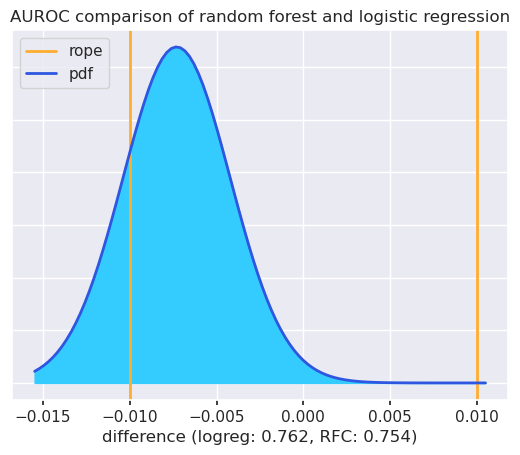

In [128]:
# statistical test comparing performance
rfc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=rfc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'RFC'), plot=True)
plt.title("AUROC comparison of random forest and logistic regression")
print(rfc_vs_logreg)

In [129]:
# statistical test comparing performance
hgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=hgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'GBTC'), plot=True)
plt.title("AUROC comparison of gradient boosting trees and logistic regression")
print(hgbc_vs_logreg)

((0.00788285924022995, 0.9920532444833751, 6.389627639502571e-05), <Figure size 640x480 with 1 Axes>)


((2.9473436444987397e-49, 0.0, 1.0), <Figure size 640x480 with 1 Axes>)


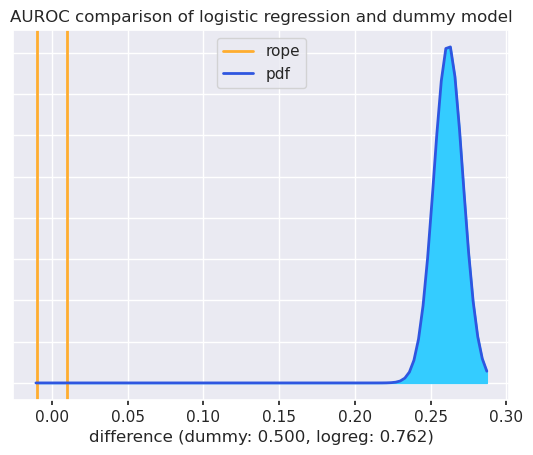

In [130]:
# statistical test comparing performance
logreg_vs_dummy = two_on_single(x=dummy_results["test_roc_auc"], y=logreg_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('dummy', 'logreg'), plot=True)
plt.title("AUROC comparison of logistic regression and dummy model")
print(logreg_vs_dummy)

## nssi_year

In [23]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# confirm new size of data set
nssi_year_data.shape

(2401, 18)

In [24]:
# define target
target = nssi_year_data['nssi_year']

# define features
features = nssi_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [26]:
# always predict median target value
dummy_results = cross_validate(DummyRegressor(strategy='median'), features, target, 
                               scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                               cv=cross_val)
print('The mean RMSE with cross-validation is: ' 
      f'{-dummy_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {dummy_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 94.948 +/- 26.975
The mean Poisson deviance with cross-validation is: 153.502 +/- 54.303


In [27]:
# compute target predictions for later plots
model = DummyRegressor(strategy='median')
model.fit(features, target)
target_predicted_dummy = model.predict(features)

### Poisson regression model

In [28]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [29]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [30]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'poissonregressor__alpha': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [31]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'poissonregressor__alpha': 2}
with Poisson deviance of 73.316
Best hyperparameters for split #2:
{'poissonregressor__alpha': 5}
with Poisson deviance of 101.060
Best hyperparameters for split #3:
{'poissonregressor__alpha': 5}
with Poisson deviance of 70.577
Best hyperparameters for split #4:
{'poissonregressor__alpha': 2}
with Poisson deviance of 99.453
Best hyperparameters for split #5:
{'poissonregressor__alpha': 2}
with Poisson deviance of 46.331


alpha of 2 appears best.

In [32]:
pipeline.set_params(poissonregressor__alpha=2)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 89.948 +/- 24.689
The mean Poisson deviance with cross-validation is: 76.436 +/- 22.248


In [33]:
# compute target predictions for later plots
target_predicted_poisson = cross_val_predict(pipeline, features, target, cv=10)

### Random forest model

In [34]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [35]:
# define algorithm
rfr = RandomForestRegressor(criterion='poisson', n_jobs=-1, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfr)

In [36]:
# hyperparameter values to try
param_grid =  {
    'randomforestregressor__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestregressor__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestregressor__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [37]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestregressor__n_estimators': 200, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.1}
with Poisson deviance of 70.542
Best hyperparameters for split #2:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.1}
with Poisson deviance of 107.798
Best hyperparameters for split #3:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 256, 'randomforestregressor__max_features': 0.1}
with Poisson deviance of 78.659
Best hyperparameters for split #4:
{'randomforestregressor__n_estimators': 500, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 106.062
Best hyperparameters for split #5:
{'randomforestregressor__n_estimators': 100, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.1}
with Poisson deviance of

We'll try a more focused search around these results.

In [38]:
pipeline.set_params(randomforestregressor__max_features=0.1)
pipeline.set_params(randomforestregressor__n_estimators=300)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [16, 32, 64, 128, 256, 512, 1024]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

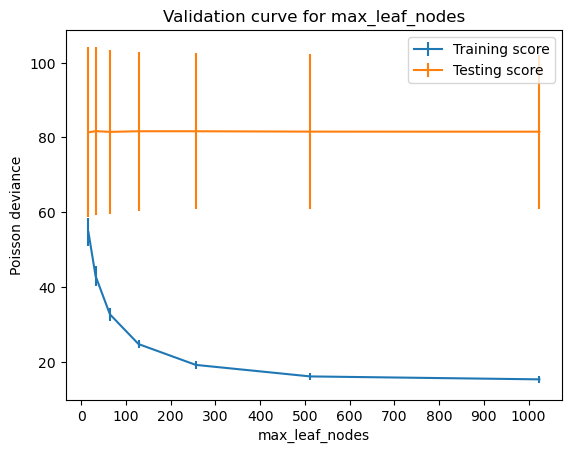

In [39]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 1100, 100))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

In [40]:
# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

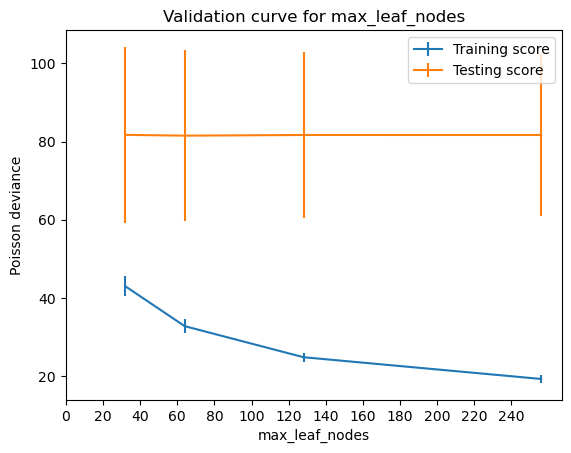

In [41]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 260, 20))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

In [42]:
pipeline.set_params(randomforestregressor__max_leaf_nodes=64)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400, 500, 600, 700]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__n_estimators', 
    param_range=n_estimators_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

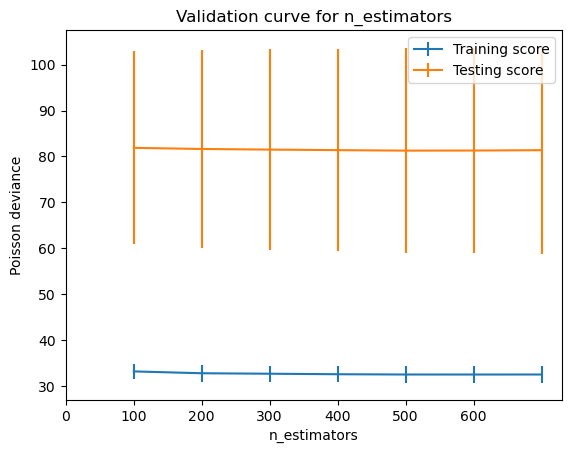

In [43]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 700, 100))
plt.xlabel("n_estimators")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for n_estimators")

We will proceed with max_leaf_nodes of 64, n_estimators of 500, and max_features of 0.1.

In [44]:
pipeline.set_params(randomforestregressor__max_features=0.1)
pipeline.set_params(randomforestregressor__max_leaf_nodes=64)
pipeline.set_params(randomforestregressor__n_estimators=500)

# get results from tuned model
rfr_results = cross_validate(pipeline, features, target, 
                             scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'],
                             cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-rfr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {rfr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 91.063 +/- 25.218
The mean Poisson deviance with cross-validation is: 80.341 +/- 23.049


In [45]:
# compute target predictions for later plots
target_predicted_rfr = cross_val_predict(pipeline, features, target, cv=10)

### Gradient boosting decision trees model

In [46]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [47]:
# define algorithm
hgbr = HistGradientBoostingRegressor(loss='poisson', random_state=0, 
                                     categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbr)

In [48]:
## hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'histgradientboostingregressor__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingregressor__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [49]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 77.839
Best hyperparameters for split #2:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 102.969
Best hyperparameters for split #3:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 80.225
Best hyperparameters for split #4:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 109.269
Best hyperparameters for split #5:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 45.804


Let's examine max_leaf_nodes while holding max_iter at 50.

In [50]:
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 16, 32, 48]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

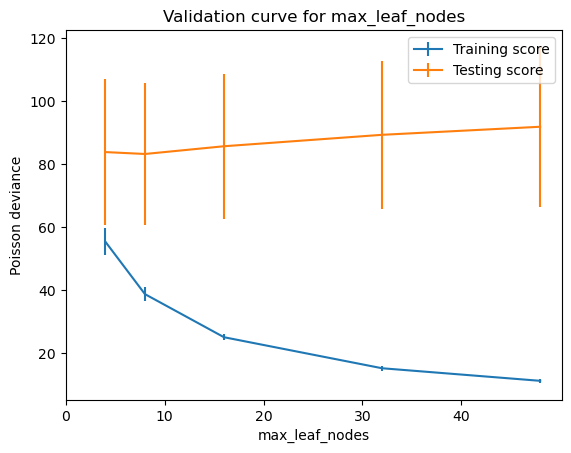

In [51]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 50, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 8 appears sufficient.

In [52]:
pipeline.set_params(histgradientboostingregressor__max_leaf_nodes=8)
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# get results from tuned model
hgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-hgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {hgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 92.816 +/- 24.142
The mean Poisson deviance with cross-validation is: 82.291 +/- 24.323


In [53]:
# compute target predictions for later plots
target_predicted_hgbr = cross_val_predict(pipeline, features, target, cv=10)

### Model comparison

In [54]:
print('Dummy baseline model')
print('Poisson deviance: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print('Poisson model')
print('Poisson deviance: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Random forest model')
print('Poisson deviance: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Gradient boosting decision trees model')
print('Poisson deviance: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()

Dummy baseline model
Poisson deviance: 153.502 +/- 54.303

Poisson model
Poisson deviance: 76.436 +/- 22.248


Random forest model
Poisson deviance: 80.341 +/- 23.049


Gradient boosting decision trees model
Poisson deviance: 82.291 +/- 24.323



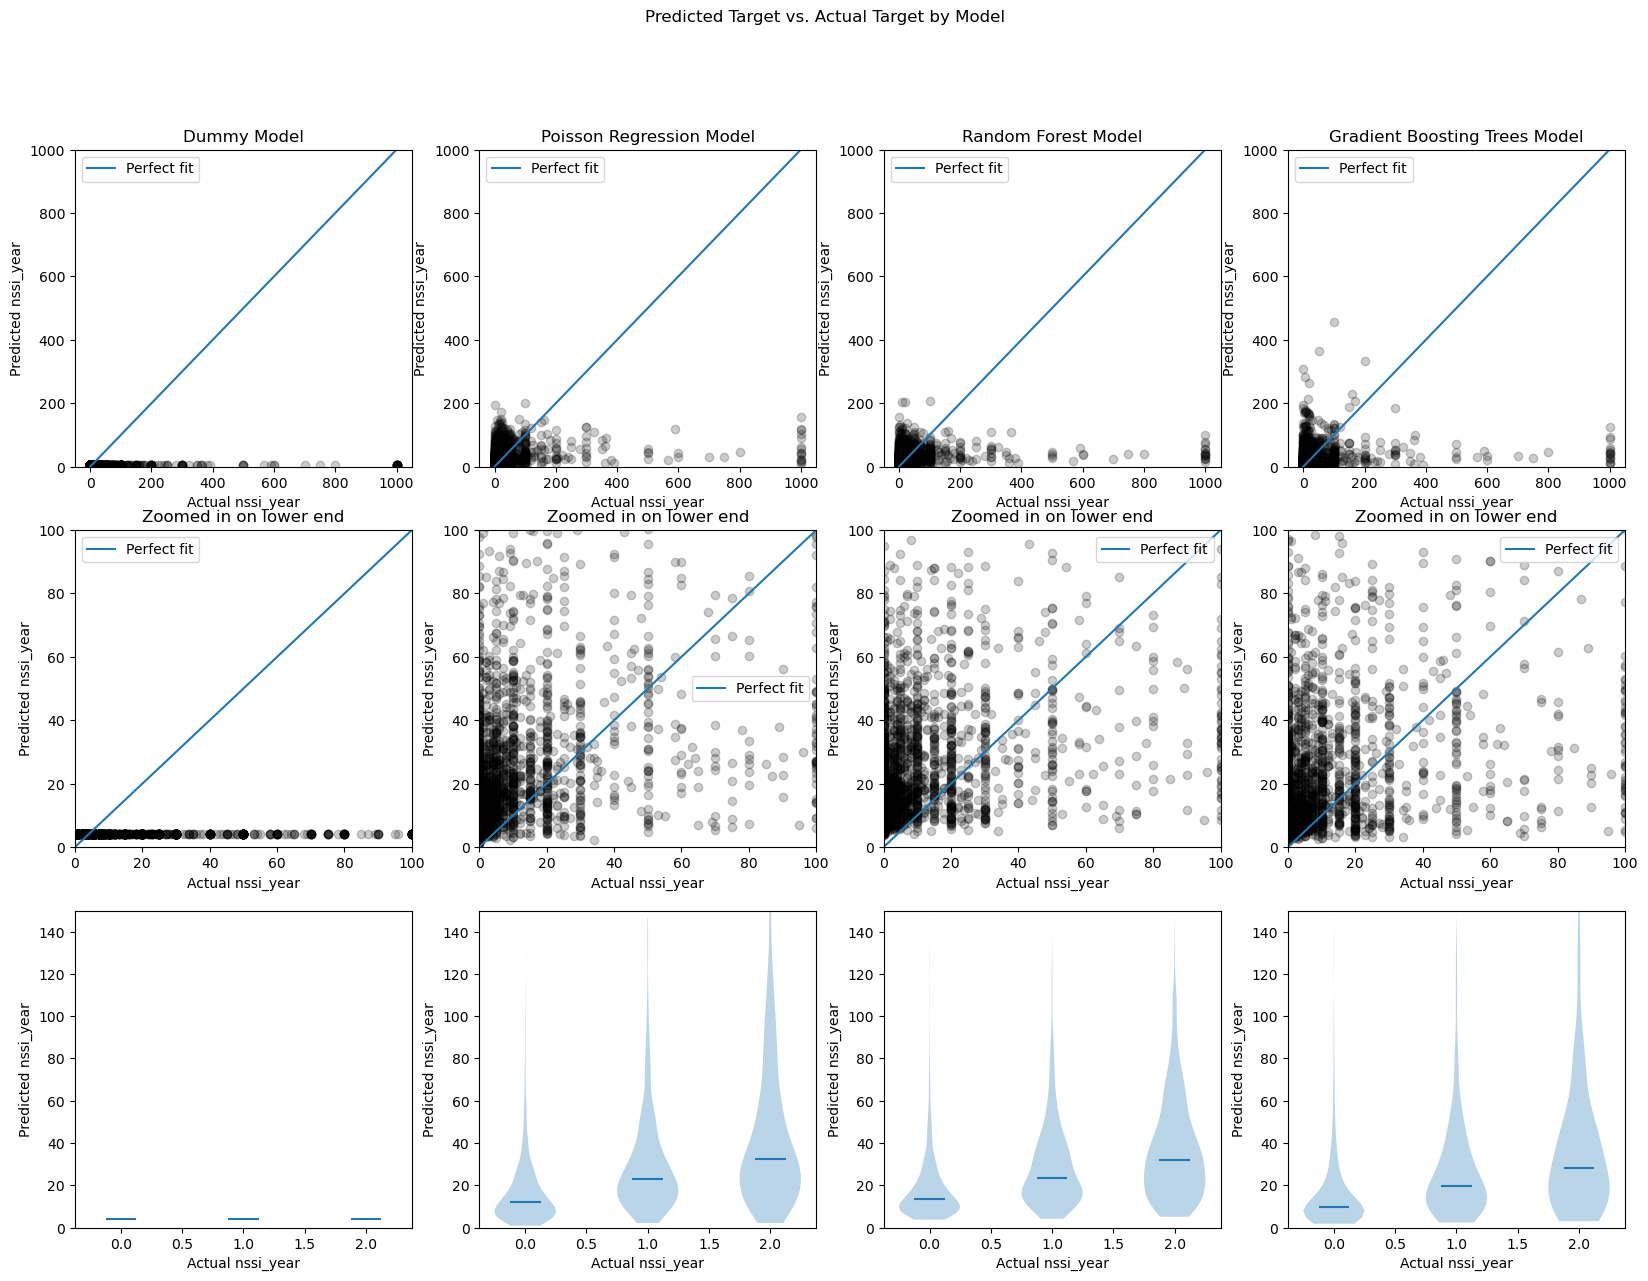

In [55]:
# plot predicted target vs. actual target
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
fig.suptitle('Predicted Target vs. Actual Target by Model')

target_quart = pd.qcut(target, 4, labels=False, duplicates='drop')

axes[0,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[0,0].set_ylim(min(target), max(target))
axes[0,0].set_xlabel("Actual nssi_year")
axes[0,0].set_ylabel("Predicted nssi_year")
axes[0,0].axline((0, 0), slope=1, label="Perfect fit")
axes[0,0].legend()
axes[0,0].set_title("Dummy Model")

axes[1,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[1,0].set_xlim(min(target), 100)
axes[1,0].set_ylim(min(target), 100)
axes[1,0].set_xlabel("Actual nssi_year")
axes[1,0].set_ylabel("Predicted nssi_year")
axes[1,0].axline((0, 0), slope=1, label="Perfect fit")
axes[1,0].legend()
axes[1,0].set_title("Zoomed in on lower end")

quart0 = target_predicted_dummy[target_quart == 0]
quart1 = target_predicted_dummy[target_quart == 1]
quart2 = target_predicted_dummy[target_quart == 2]
axes[2,0].violinplot([quart0, quart1, quart2], positions=[0,1,2], showextrema=False, showmedians=True)
axes[2,0].set_xlabel("Actual nssi_year")
axes[2,0].set_ylabel("Predicted nssi_year")
axes[2,0].set_ylim(0, 150)

axes[0,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[0,1].set_ylim(min(target), max(target))
axes[0,1].set_xlabel("Actual nssi_year")
axes[0,1].set_ylabel("Predicted nssi_year")
axes[0,1].axline((0, 0), slope=1, label="Perfect fit")
axes[0,1].legend()
axes[0,1].set_title("Poisson Regression Model")

axes[1,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[1,1].set_xlim(min(target), 100)
axes[1,1].set_ylim(min(target), 100)
axes[1,1].set_xlabel("Actual nssi_year")
axes[1,1].set_ylabel("Predicted nssi_year")
axes[1,1].axline((0, 0), slope=1, label="Perfect fit")
axes[1,1].legend()
axes[1,1].set_title("Zoomed in on lower end")

quart0 = target_predicted_poisson[target_quart == 0]
quart1 = target_predicted_poisson[target_quart == 1]
quart2 = target_predicted_poisson[target_quart == 2]
axes[2,1].violinplot([quart0, quart1, quart2], positions=[0,1,2], showextrema=False, showmedians=True)
axes[2,1].set_xlabel("Actual nssi_year")
axes[2,1].set_ylabel("Predicted nssi_year")
axes[2,1].set_ylim(0, 150)

axes[0,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[0,2].set_ylim(min(target), max(target))
axes[0,2].set_xlabel("Actual nssi_year")
axes[0,2].set_ylabel("Predicted nssi_year")
axes[0,2].axline((0, 0), slope=1, label="Perfect fit")
axes[0,2].legend()
axes[0,2].set_title("Random Forest Model")

axes[1,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[1,2].set_xlim(min(target), 100)
axes[1,2].set_ylim(min(target), 100)
axes[1,2].set_xlabel("Actual nssi_year")
axes[1,2].set_ylabel("Predicted nssi_year")
axes[1,2].axline((0, 0), slope=1, label="Perfect fit")
axes[1,2].legend()
axes[1,2].set_title("Zoomed in on lower end")

quart0 = target_predicted_rfr[target_quart == 0]
quart1 = target_predicted_rfr[target_quart == 1]
quart2 = target_predicted_rfr[target_quart == 2]
axes[2,2].violinplot([quart0, quart1, quart2], positions=[0,1,2], showextrema=False, showmedians=True)
axes[2,2].set_xlabel("Actual nssi_year")
axes[2,2].set_ylabel("Predicted nssi_year")
axes[2,2].set_ylim(0, 150)

axes[0,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[0,3].set_ylim(min(target), max(target))
axes[0,3].set_xlabel("Actual nssi_year")
axes[0,3].set_ylabel("Predicted nssi_year")
axes[0,3].axline((0, 0), slope=1, label="Perfect fit")
axes[0,3].legend()
axes[0,3].set_title("Gradient Boosting Trees Model")

axes[1,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[1,3].set_xlim(min(target), 100)
axes[1,3].set_ylim(min(target), 100)
axes[1,3].set_xlabel("Actual nssi_year")
axes[1,3].set_ylabel("Predicted nssi_year")
axes[1,3].axline((0, 0), slope=1, label="Perfect fit")
axes[1,3].legend()
axes[1,3].set_title("Zoomed in on lower end")

quart0 = target_predicted_hgbr[target_quart == 0]
quart1 = target_predicted_hgbr[target_quart == 1]
quart2 = target_predicted_hgbr[target_quart == 2]
axes[2,3].violinplot([quart0, quart1, quart2], positions=[0,1,2], showextrema=False, showmedians=True)
axes[2,3].set_xlabel("Actual nssi_year")
axes[2,3].set_ylabel("Predicted nssi_year")
axes[2,3].set_ylim(0, 150)

None

((0.00034403896143791335, 0.1300770979599234, 0.8695788630786387), <Figure size 640x480 with 1 Axes>)


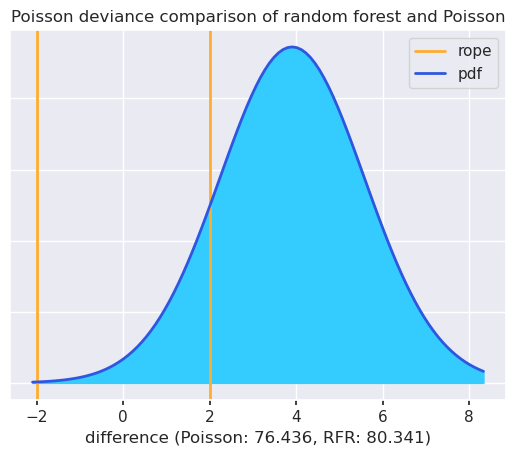

In [56]:
# statistical test comparing performance
rfr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                               y=-rfr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'RFR'), plot=True)
plt.title("Poisson deviance comparison of random forest and Poisson")
print(rfr_vs_poisson)

In [57]:
# statistical test comparing performance
hgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-hgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'HGBR'), plot=True)
plt.title("Poisson deviance comparison of gradient boosting trees and Poisson")
print(hgbr_vs_poisson)

((7.358609811406959e-06, 0.013741929779268025, 0.9862507116109206), <Figure size 640x480 with 1 Axes>)


((0.9999999936973625, 4.936991371273791e-09, 1.3656461517186358e-09), <Figure size 640x480 with 1 Axes>)


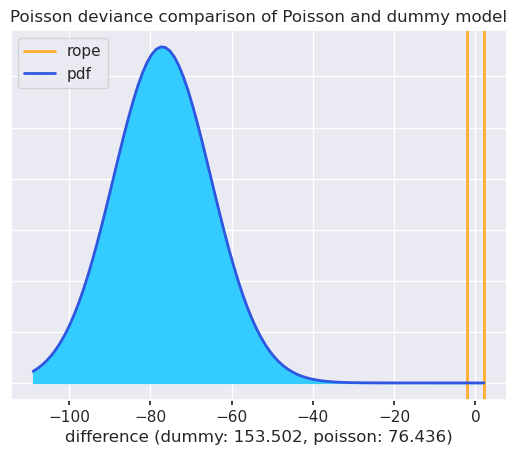

In [58]:
# statistical test comparing performance
poisson_vs_dummy = two_on_single(x=-dummy_results["test_neg_mean_poisson_deviance"], 
                                 y=-poisson_results["test_neg_mean_poisson_deviance"], 
                                 rope=2, runs=10, names=('dummy', 'poisson'), plot=True)
plt.title("Poisson deviance comparison of Poisson and dummy model")
print(poisson_vs_dummy)

## si_year

In [59]:
# drop records missing si_year for si_year models
si_year_data = data.dropna(subset='si_year')

# confirm new size of data set
si_year_data.shape

(2415, 18)

In [60]:
# define target
target = si_year_data['si_year']

# define features
features = si_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [62]:
# always predict median target value
dummy_results = cross_validate(DummyRegressor(strategy='median'), features, target, 
                               scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                               cv=cross_val)
print('The mean RMSE with cross-validation is: ' 
      f'{-dummy_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {dummy_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 164.603 +/- 21.621
The mean Poisson deviance with cross-validation is: 318.354 +/- 59.998


In [63]:
# compute target predictions for later plots
model = DummyRegressor(strategy='median')
model.fit(features, target)
target_predicted_dummy = model.predict(features)

### Poisson regression model

In [64]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [65]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [66]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'poissonregressor__alpha': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [67]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'poissonregressor__alpha': 10}
with Poisson deviance of 123.484
Best hyperparameters for split #2:
{'poissonregressor__alpha': 10}
with Poisson deviance of 158.827
Best hyperparameters for split #3:
{'poissonregressor__alpha': 10}
with Poisson deviance of 128.401
Best hyperparameters for split #4:
{'poissonregressor__alpha': 5}
with Poisson deviance of 137.083
Best hyperparameters for split #5:
{'poissonregressor__alpha': 10}
with Poisson deviance of 130.923


In [68]:
# zoom in around 5 and 10 with validation curve
alpha_values = [5, 10, 15, 20, 30, 50]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='poissonregressor__alpha', 
    param_range=alpha_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

In [69]:
# plot validation curve for alpha
plt.errorbar(alpha_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(alpha_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 60, 10))
plt.xlabel("alpha")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for alpha")

alpha of 10 appears best.

In [70]:
pipeline.set_params(poissonregressor__alpha=10)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 145.918 +/- 18.969
The mean Poisson deviance with cross-validation is: 135.715 +/- 21.016


In [71]:
# compute target predictions for later plots
target_predicted_poisson = cross_val_predict(pipeline, features, target, cv=10)

### Random forest model

In [72]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [73]:
# define algorithm
rfr = RandomForestRegressor(criterion='poisson', n_jobs=-1, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfr)

In [74]:
# hyperparameter values to try
param_grid =  {
    'randomforestregressor__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestregressor__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestregressor__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [75]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestregressor__n_estimators': 500, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 126.689
Best hyperparameters for split #2:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 164.062
Best hyperparameters for split #3:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.3}
with Poisson deviance of 130.340
Best hyperparameters for split #4:
{'randomforestregressor__n_estimators': 100, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 137.484
Best hyperparameters for split #5:
{'randomforestregressor__n_estimators': 100, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.3}
with Poisson deviance o

We'll try a more focused search around these results.

In [76]:
pipeline.set_params(randomforestregressor__max_features=0.2)
pipeline.set_params(randomforestregressor__n_estimators=100)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [8, 16, 32, 64, 128]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

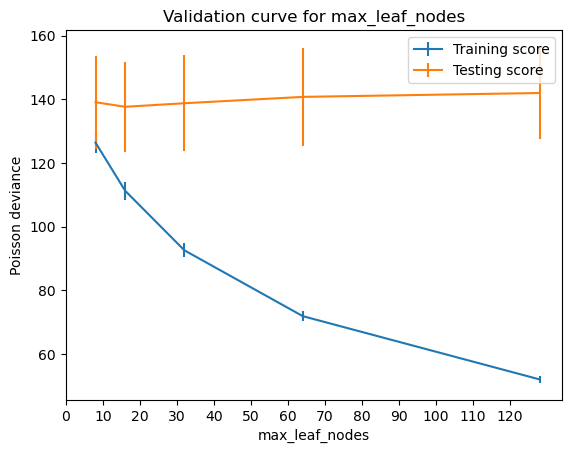

In [77]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 130, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

In [78]:
pipeline.set_params(randomforestregressor__max_leaf_nodes=16)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400, 500, 600, 700]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__n_estimators', 
    param_range=n_estimators_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

In [79]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 700, 100))
plt.xlabel("n_estimators")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for n_estimators")

We will proceed with max_leaf_nodes of 16, n_estimators of 300, and max_features of 0.2.

In [80]:
pipeline.set_params(randomforestregressor__max_features=0.2)
pipeline.set_params(randomforestregressor__max_leaf_nodes=16)
pipeline.set_params(randomforestregressor__n_estimators=300)

# get results from tuned model
rfr_results = cross_validate(pipeline, features, target, 
                             scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'],
                             cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-rfr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {rfr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 146.297 +/- 18.973
The mean Poisson deviance with cross-validation is: 138.163 +/- 20.080


In [81]:
# compute target predictions for later plots
target_predicted_rfr = cross_val_predict(pipeline, features, target, cv=10)

### Gradient boosting decision trees model

In [82]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [83]:
# define algorithm
hgbr = HistGradientBoostingRegressor(loss='poisson', random_state=0, 
                                     categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbr)

In [84]:
## hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'histgradientboostingregressor__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingregressor__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [85]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 126.881
Best hyperparameters for split #2:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 157.444
Best hyperparameters for split #3:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 133.822
Best hyperparameters for split #4:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 142.163
Best hyperparameters for split #5:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 132.801


Let's examine max_leaf_nodes while holding max_iter at 50.

In [86]:
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 16, 32, 48]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

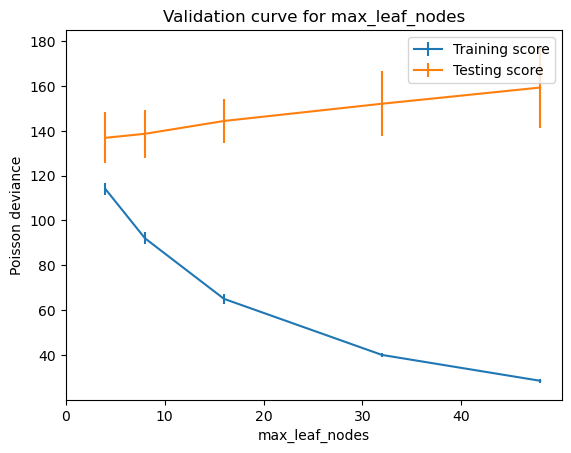

In [87]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 50, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [88]:
pipeline.set_params(histgradientboostingregressor__max_leaf_nodes=4)
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# get results from tuned model
hgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-hgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {hgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 146.355 +/- 18.932
The mean Poisson deviance with cross-validation is: 137.386 +/- 21.747


In [89]:
# compute target predictions for later plots
target_predicted_hgbr = cross_val_predict(pipeline, features, target, cv=10)

### Model comparison

In [90]:
print('Dummy baseline model')
print('Poisson deviance: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print('Poisson model')
print('Poisson deviance: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Random forest model')
print('Poisson deviance: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Gradient boosting decision trees model')
print('Poisson deviance: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()

Dummy baseline model
Poisson deviance: 318.354 +/- 59.998

Poisson model
Poisson deviance: 135.715 +/- 21.016


Random forest model
Poisson deviance: 138.163 +/- 20.080


Gradient boosting decision trees model
Poisson deviance: 137.386 +/- 21.747



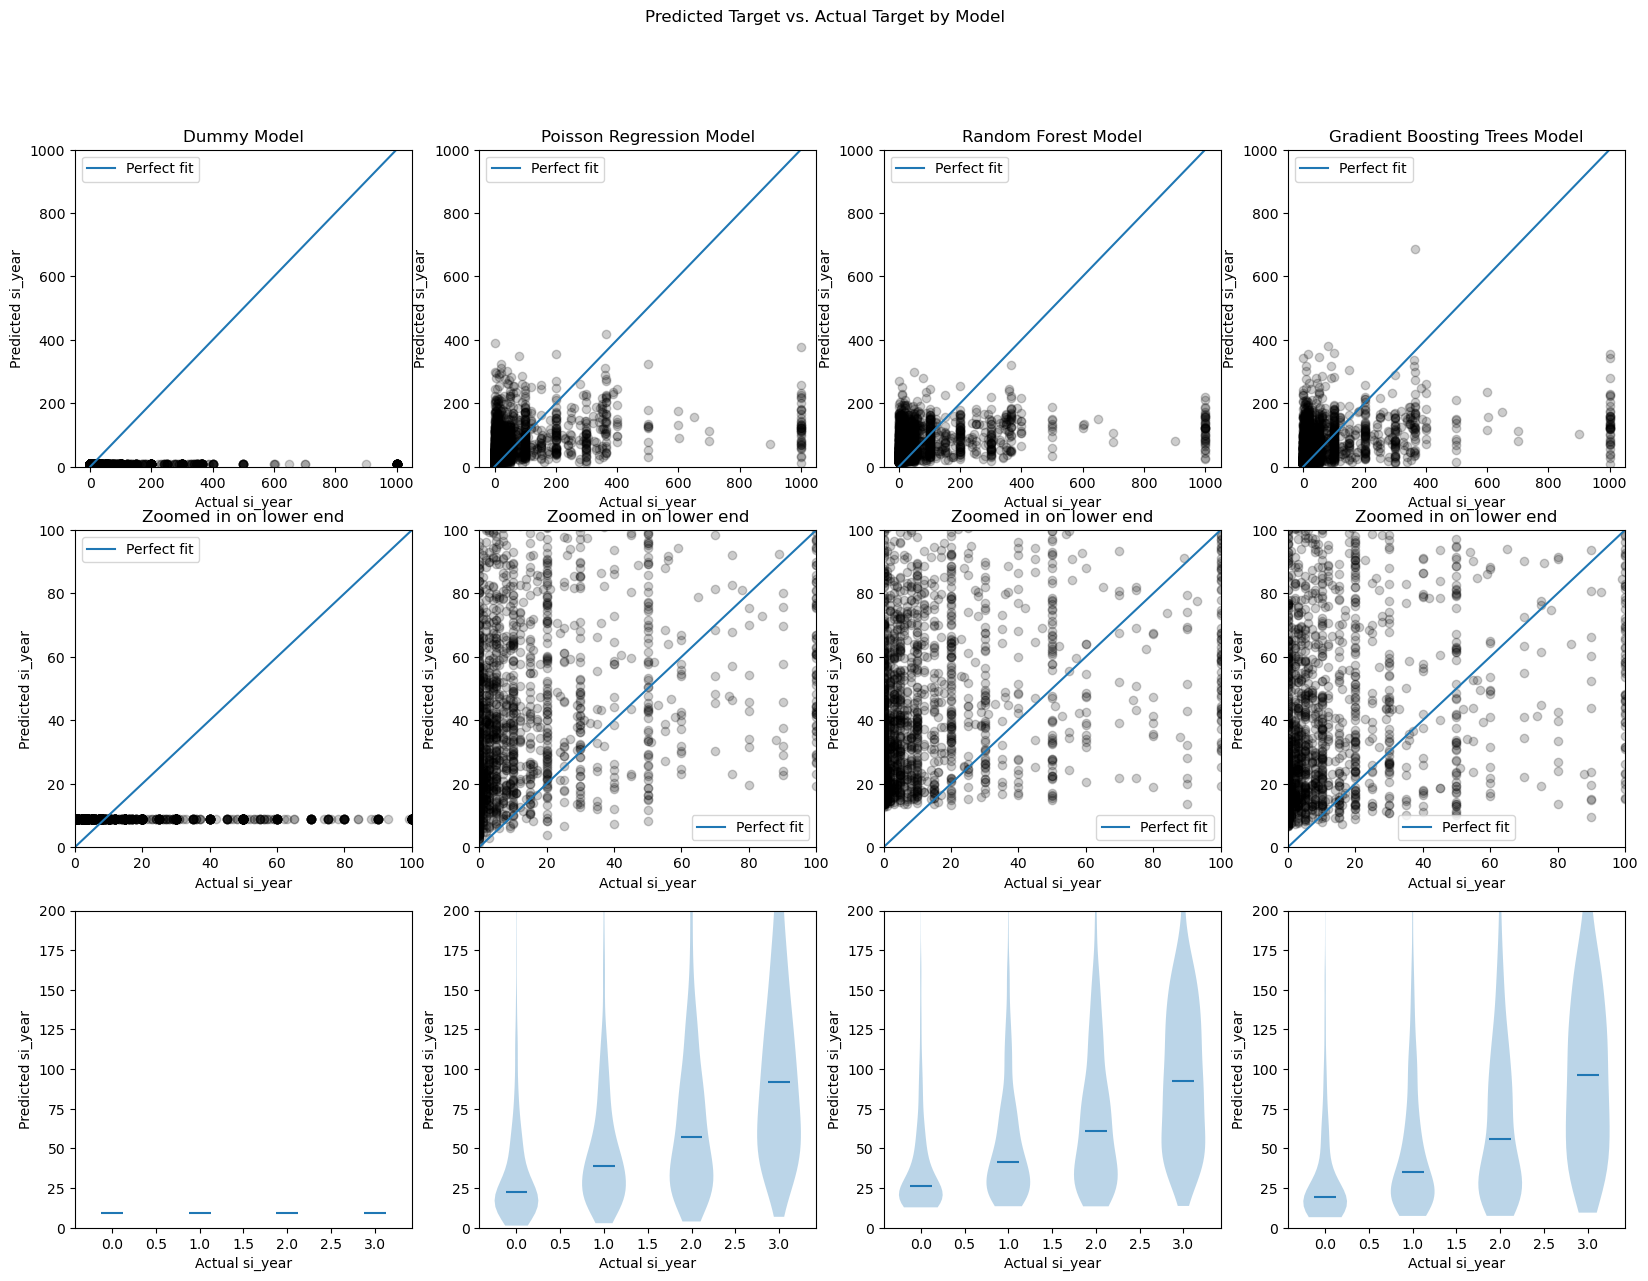

In [91]:
# plot predicted target vs. actual target
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
fig.suptitle('Predicted Target vs. Actual Target by Model')

target_quart = pd.qcut(target, 4, labels=False, duplicates='drop')

axes[0,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[0,0].set_ylim(min(target), max(target))
axes[0,0].set_xlabel("Actual si_year")
axes[0,0].set_ylabel("Predicted si_year")
axes[0,0].axline((0, 0), slope=1, label="Perfect fit")
axes[0,0].legend()
axes[0,0].set_title("Dummy Model")

axes[1,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[1,0].set_xlim(min(target), 100)
axes[1,0].set_ylim(min(target), 100)
axes[1,0].set_xlabel("Actual si_year")
axes[1,0].set_ylabel("Predicted si_year")
axes[1,0].axline((0, 0), slope=1, label="Perfect fit")
axes[1,0].legend()
axes[1,0].set_title("Zoomed in on lower end")

quart0 = target_predicted_dummy[target_quart == 0]
quart1 = target_predicted_dummy[target_quart == 1]
quart2 = target_predicted_dummy[target_quart == 2]
quart3 = target_predicted_dummy[target_quart == 3]
axes[2,0].violinplot([quart0, quart1, quart2, quart3], positions=[0,1,2,3], showextrema=False, showmedians=True)
axes[2,0].set_xlabel("Actual si_year")
axes[2,0].set_ylabel("Predicted si_year")
axes[2,0].set_ylim(0, 200)

axes[0,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[0,1].set_ylim(min(target), max(target))
axes[0,1].set_xlabel("Actual si_year")
axes[0,1].set_ylabel("Predicted si_year")
axes[0,1].axline((0, 0), slope=1, label="Perfect fit")
axes[0,1].legend()
axes[0,1].set_title("Poisson Regression Model")

axes[1,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[1,1].set_xlim(min(target), 100)
axes[1,1].set_ylim(min(target), 100)
axes[1,1].set_xlabel("Actual si_year")
axes[1,1].set_ylabel("Predicted si_year")
axes[1,1].axline((0, 0), slope=1, label="Perfect fit")
axes[1,1].legend()
axes[1,1].set_title("Zoomed in on lower end")

quart0 = target_predicted_poisson[target_quart == 0]
quart1 = target_predicted_poisson[target_quart == 1]
quart2 = target_predicted_poisson[target_quart == 2]
quart3 = target_predicted_poisson[target_quart == 3]
axes[2,1].violinplot([quart0, quart1, quart2, quart3], positions=[0,1,2,3], showextrema=False, showmedians=True)
axes[2,1].set_xlabel("Actual si_year")
axes[2,1].set_ylabel("Predicted si_year")
axes[2,1].set_ylim(0, 200)

axes[0,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[0,2].set_ylim(min(target), max(target))
axes[0,2].set_xlabel("Actual si_year")
axes[0,2].set_ylabel("Predicted si_year")
axes[0,2].axline((0, 0), slope=1, label="Perfect fit")
axes[0,2].legend()
axes[0,2].set_title("Random Forest Model")

axes[1,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[1,2].set_xlim(min(target), 100)
axes[1,2].set_ylim(min(target), 100)
axes[1,2].set_xlabel("Actual si_year")
axes[1,2].set_ylabel("Predicted si_year")
axes[1,2].axline((0, 0), slope=1, label="Perfect fit")
axes[1,2].legend()
axes[1,2].set_title("Zoomed in on lower end")

quart0 = target_predicted_rfr[target_quart == 0]
quart1 = target_predicted_rfr[target_quart == 1]
quart2 = target_predicted_rfr[target_quart == 2]
quart3 = target_predicted_rfr[target_quart == 3]
axes[2,2].violinplot([quart0, quart1, quart2, quart3], positions=[0,1,2,3], showextrema=False, showmedians=True)
axes[2,2].set_xlabel("Actual si_year")
axes[2,2].set_ylabel("Predicted si_year")
axes[2,2].set_ylim(0, 200)

axes[0,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[0,3].set_ylim(min(target), max(target))
axes[0,3].set_xlabel("Actual si_year")
axes[0,3].set_ylabel("Predicted si_year")
axes[0,3].axline((0, 0), slope=1, label="Perfect fit")
axes[0,3].legend()
axes[0,3].set_title("Gradient Boosting Trees Model")

axes[1,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[1,3].set_xlim(min(target), 100)
axes[1,3].set_ylim(min(target), 100)
axes[1,3].set_xlabel("Actual si_year")
axes[1,3].set_ylabel("Predicted si_year")
axes[1,3].axline((0, 0), slope=1, label="Perfect fit")
axes[1,3].legend()
axes[1,3].set_title("Zoomed in on lower end")

quart0 = target_predicted_hgbr[target_quart == 0]
quart1 = target_predicted_hgbr[target_quart == 1]
quart2 = target_predicted_hgbr[target_quart == 2]
quart3 = target_predicted_hgbr[target_quart == 3]
axes[2,3].violinplot([quart0, quart1, quart2, quart3], positions=[0,1,2,3], showextrema=False, showmedians=True)
axes[2,3].set_xlabel("Actual si_year")
axes[2,3].set_ylabel("Predicted si_year")
axes[2,3].set_ylim(0, 200)

None

((0.003099604513586365, 0.3862516168018898, 0.6106487786845238), <Figure size 640x480 with 1 Axes>)


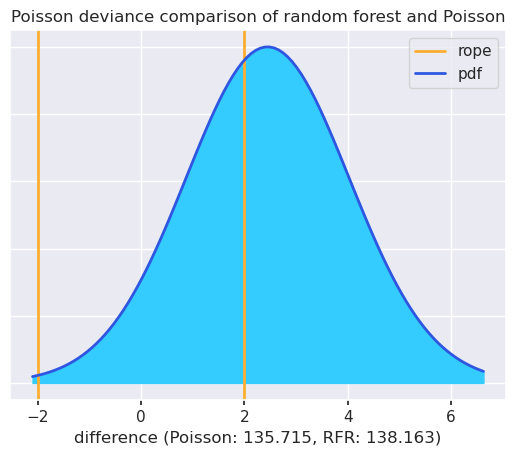

In [92]:
# statistical test comparing performance
rfr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                               y=-rfr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'RFR'), plot=True)
plt.title("Poisson deviance comparison of random forest and Poisson")
print(rfr_vs_poisson)

((0.013449636013910563, 0.5661453009922692, 0.4204050629938202), <Figure size 640x480 with 1 Axes>)


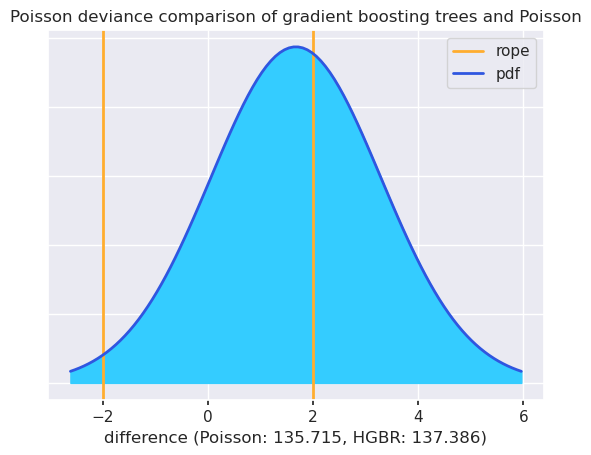

In [93]:
# statistical test comparing performance
hgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-hgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'HGBR'), plot=True)
plt.title("Poisson deviance comparison of gradient boosting trees and Poisson")
print(hgbr_vs_poisson)

In [94]:
# statistical test comparing performance
poisson_vs_dummy = two_on_single(x=-dummy_results["test_neg_mean_poisson_deviance"], 
                                 y=-poisson_results["test_neg_mean_poisson_deviance"], 
                                 rope=2, runs=10, names=('dummy', 'poisson'), plot=True)
plt.title("Poisson deviance comparison of Poisson and dummy model")
print(poisson_vs_dummy)

((1.0, 0.0, 0.0), <Figure size 640x480 with 1 Axes>)


## attempt_year

In [3]:
# drop records missing attempt_year for attempt_year models
attempt_year_data = data.dropna(subset='attempt_year')

# confirm new size of data set
attempt_year_data.shape

(2442, 18)

In [4]:
# define target
target = attempt_year_data['attempt_year']

# define features
features = attempt_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [5]:
# always predict median target value
dummy_results = cross_validate(DummyRegressor(strategy='mean'), features, target, 
                               scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                               cv=cross_val)
print('The mean RMSE with cross-validation is: ' 
      f'{-dummy_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {dummy_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.127 +/- 0.772
The mean Poisson deviance with cross-validation is: 2.548 +/- 0.705


In [6]:
# compute target predictions for later plots
model = DummyRegressor(strategy='median')
model.fit(features, target)
target_predicted_dummy = model.predict(features)

### Poisson regression model

In [7]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [8]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [9]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'poissonregressor__alpha': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [10]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'poissonregressor__alpha': 0.1}
with Poisson deviance of 1.540
Best hyperparameters for split #2:
{'poissonregressor__alpha': 0.1}
with Poisson deviance of 2.397
Best hyperparameters for split #3:
{'poissonregressor__alpha': 0.1}
with Poisson deviance of 1.879
Best hyperparameters for split #4:
{'poissonregressor__alpha': 0.1}
with Poisson deviance of 1.881
Best hyperparameters for split #5:
{'poissonregressor__alpha': 0.1}
with Poisson deviance of 1.747


In [11]:
# zoom in around 0.1 with validation curve
alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='poissonregressor__alpha', 
    param_range=alpha_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

In [12]:
# plot validation curve for alpha
plt.errorbar(alpha_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(alpha_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 1, 0.1))
plt.xlabel("alpha")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for alpha")

alpha of 0.2 appears best.

In [13]:
pipeline.set_params(poissonregressor__alpha=0.2)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.008 +/- 0.730
The mean Poisson deviance with cross-validation is: 1.873 +/- 0.451


In [14]:
# compute target predictions for later plots
target_predicted_poisson = cross_val_predict(pipeline, features, target, cv=10)

### Random forest model

In [15]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [16]:
# define algorithm
rfr = RandomForestRegressor(criterion='poisson', n_jobs=-1, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfr)

In [17]:
# hyperparameter values to try
param_grid =  {
    'randomforestregressor__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestregressor__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestregressor__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [18]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestregressor__n_estimators': 300, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 1.636
Best hyperparameters for split #2:
{'randomforestregressor__n_estimators': 300, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.3}
with Poisson deviance of 2.437
Best hyperparameters for split #3:
{'randomforestregressor__n_estimators': 200, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 1.934
Best hyperparameters for split #4:
{'randomforestregressor__n_estimators': 500, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.3}
with Poisson deviance of 1.819
Best hyperparameters for split #5:
{'randomforestregressor__n_estimators': 500, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.3}
with Poisson deviance of 1.739


We'll try a more focused search around these results.

In [19]:
pipeline.set_params(randomforestregressor__max_features=0.3)
pipeline.set_params(randomforestregressor__n_estimators=300)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [8, 16, 32, 64, 128]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

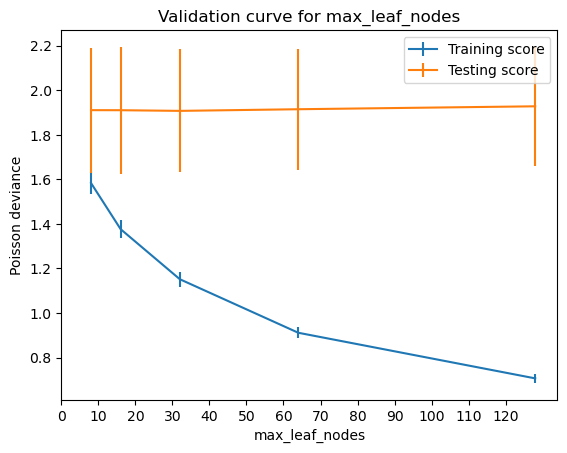

In [20]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 130, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

In [21]:
pipeline.set_params(randomforestregressor__max_leaf_nodes=32)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400, 500, 600, 700]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__n_estimators', 
    param_range=n_estimators_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

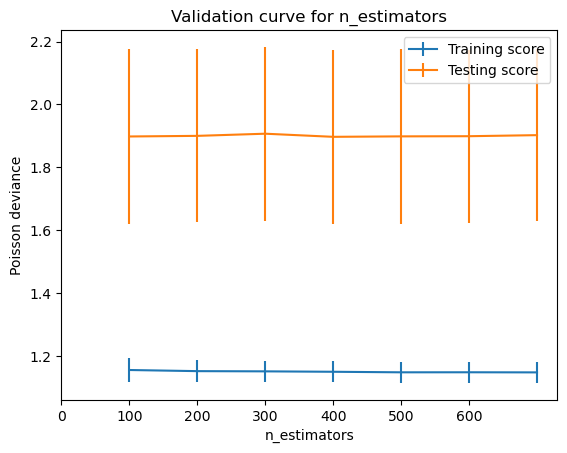

In [22]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 700, 100))
plt.xlabel("n_estimators")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for n_estimators")

In [23]:
pipeline.set_params(randomforestregressor__n_estimators=400)

# generate validation curve for max_features
max_features_values = [0.1, 0.2, 0.3, 0.4, 0.5]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_features', 
    param_range=max_features_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

In [24]:
# plot validation curve for max_features
plt.errorbar(max_features_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_features_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.6, 0.1))
plt.xlabel("max_features")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_features")

We will proceed with max_leaf_nodes of 32, n_estimators of 400, and max_features of 0.4.

In [25]:
pipeline.set_params(randomforestregressor__max_features=0.4)
pipeline.set_params(randomforestregressor__max_leaf_nodes=32)
pipeline.set_params(randomforestregressor__n_estimators=400)

# get results from tuned model
rfr_results = cross_validate(pipeline, features, target, 
                             scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'],
                             cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-rfr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {rfr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.051 +/- 0.711
The mean Poisson deviance with cross-validation is: 1.898 +/- 0.436


In [26]:
# compute target predictions for later plots
target_predicted_rfr = cross_val_predict(pipeline, features, target, cv=10)

### Gradient boosting decision trees model

In [27]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [28]:
# define algorithm
hgbr = HistGradientBoostingRegressor(loss='poisson', random_state=0, 
                                     categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbr)

In [29]:
## hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'histgradientboostingregressor__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingregressor__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(grid_search, features, target, n_jobs=-1, return_estimator=True)

In [30]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 1.617
Best hyperparameters for split #2:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 2.556
Best hyperparameters for split #3:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 2.128
Best hyperparameters for split #4:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 2.148
Best hyperparameters for split #5:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 1.853


Let's examine max_leaf_nodes while holding max_iter at 50.

In [31]:
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 16, 32, 48]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=-1)

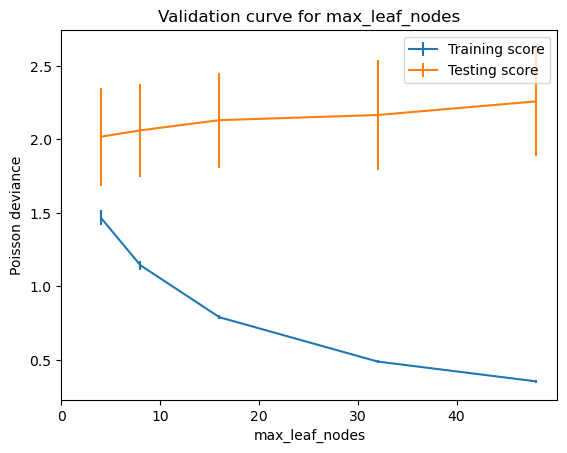

In [32]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 50, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [33]:
pipeline.set_params(histgradientboostingregressor__max_leaf_nodes=4)
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# get results from tuned model
hgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-hgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {hgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.114 +/- 0.696
The mean Poisson deviance with cross-validation is: 1.977 +/- 0.479


In [34]:
# compute target predictions for later plots
target_predicted_hgbr = cross_val_predict(pipeline, features, target, cv=10)

### Model comparison

In [35]:
print('Dummy baseline model')
print('Poisson deviance: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print('Poisson model')
print('Poisson deviance: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Random forest model')
print('Poisson deviance: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Gradient boosting decision trees model')
print('Poisson deviance: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()

Dummy baseline model
Poisson deviance: 2.548 +/- 0.705

Poisson model
Poisson deviance: 1.873 +/- 0.451


Random forest model
Poisson deviance: 1.898 +/- 0.436


Gradient boosting decision trees model
Poisson deviance: 1.977 +/- 0.479



In [36]:
# plot predicted target vs. actual target
fig, axes = plt.subplots(2, 4, figsize=(14, 10))
fig.suptitle('Predicted Target vs. Actual Target by Model')

axes[0,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[0,0].set_ylim(min(target), max(target))
axes[0,0].set_xlabel("Actual attempt_year")
axes[0,0].set_ylabel("Predicted attempt_year")
axes[0,0].axline((0, 0), slope=1, label="Perfect fit")
axes[0,0].legend()
axes[0,0].set_title("Dummy Model")

axes[1,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[1,0].set_xlim(min(target), 16)
axes[1,0].set_ylim(min(target), 16)
axes[1,0].set_xlabel("Actual attempt_year")
axes[1,0].set_ylabel("Predicted attempt_year")
axes[1,0].axline((0, 0), slope=1, label="Perfect fit")
axes[1,0].legend()
axes[1,0].set_title("Zoomed in on lower end")

axes[0,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[0,1].set_ylim(min(target), max(target))
axes[0,1].set_xlabel("Actual attempt_year")
axes[0,1].set_ylabel("Predicted attempt_year")
axes[0,1].axline((0, 0), slope=1, label="Perfect fit")
axes[0,1].legend()
axes[0,1].set_title("Poisson Regression Model")

axes[1,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[1,1].set_xlim(min(target), 16)
axes[1,1].set_ylim(min(target), 16)
axes[1,1].set_xlabel("Actual attempt_year")
axes[1,1].set_ylabel("Predicted attempt_year")
axes[1,1].axline((0, 0), slope=1, label="Perfect fit")
axes[1,1].legend()
axes[1,1].set_title("Zoomed in on lower end")

axes[0,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[0,2].set_ylim(min(target), max(target))
axes[0,2].set_xlabel("Actual attempt_year")
axes[0,2].set_ylabel("Predicted attempt_year")
axes[0,2].axline((0, 0), slope=1, label="Perfect fit")
axes[0,2].legend()
axes[0,2].set_title("Random Forest Model")

axes[1,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[1,2].set_xlim(min(target), 16)
axes[1,2].set_ylim(min(target), 16)
axes[1,2].set_xlabel("Actual attempt_year")
axes[1,2].set_ylabel("Predicted attempt_year")
axes[1,2].axline((0, 0), slope=1, label="Perfect fit")
axes[1,2].legend()
axes[1,2].set_title("Zoomed in on lower end")

axes[0,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[0,3].set_ylim(min(target), max(target))
axes[0,3].set_xlabel("Actual attempt_year")
axes[0,3].set_ylabel("Predicted attempt_year")
axes[0,3].axline((0, 0), slope=1, label="Perfect fit")
axes[0,3].legend()
axes[0,3].set_title("Gradient Boosting Trees Model")

axes[1,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[1,3].set_xlim(min(target), 16)
axes[1,3].set_ylim(min(target), 16)
axes[1,3].set_xlabel("Actual attempt_year")
axes[1,3].set_ylabel("Predicted attempt_year")
axes[1,3].axline((0, 0), slope=1, label="Perfect fit")
axes[1,3].legend()
axes[1,3].set_title("Zoomed in on lower end")

None

((1.157891573583464e-79, 1.0, 0.0), <Figure size 640x480 with 1 Axes>)


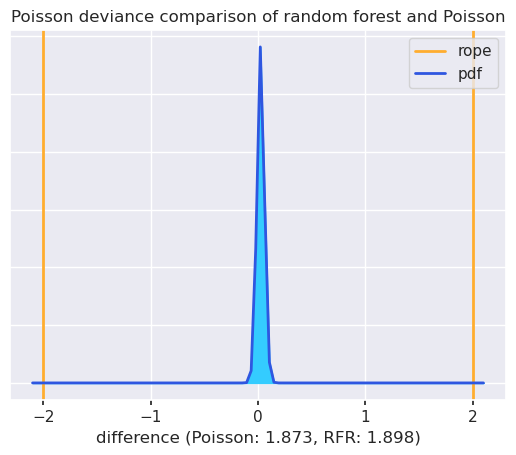

In [37]:
# statistical test comparing performance
rfr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                               y=-rfr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'RFR'), plot=True)
plt.title("Poisson deviance comparison of random forest and Poisson")
print(rfr_vs_poisson)

((1.2199982871252284e-81, 1.0, 0.0), <Figure size 640x480 with 1 Axes>)


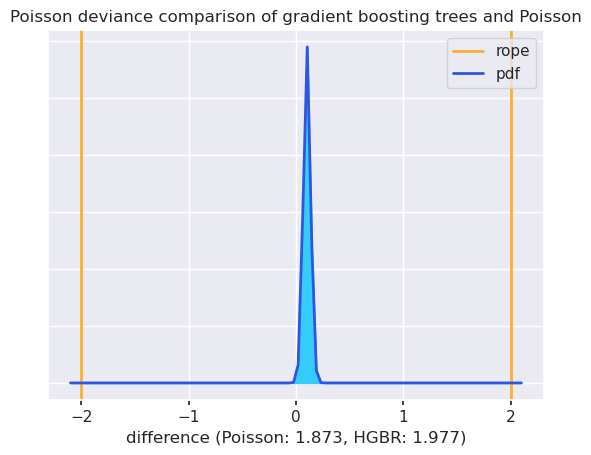

In [38]:
# statistical test comparing performance
hgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-hgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'HGBR'), plot=True)
plt.title("Poisson deviance comparison of gradient boosting trees and Poisson")
print(hgbr_vs_poisson)

((2.175248597633156e-20, 1.0, 0.0), <Figure size 640x480 with 1 Axes>)


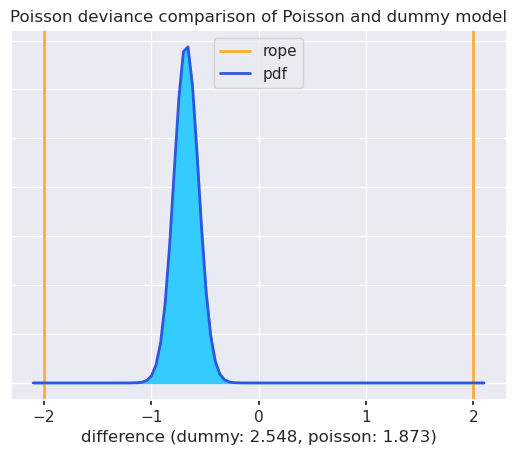

In [39]:
# statistical test comparing performance
poisson_vs_dummy = two_on_single(x=-dummy_results["test_neg_mean_poisson_deviance"], 
                                 y=-poisson_results["test_neg_mean_poisson_deviance"], 
                                 rope=2, runs=10, names=('dummy', 'poisson'), plot=True)
plt.title("Poisson deviance comparison of Poisson and dummy model")
print(poisson_vs_dummy)

# Hypothesis 2

For the categorical targets, the logistic regression models tended to have the highest values for AUROC,  
although differences in AUROC between logistic regression and random forest and gradient boosting decision trees were not significant.  
Logistic regression did significantly outperform dummy models for all categorical targets on AUROC.  
Therefore, we will use logistic regression models to test Hypothesis 2 for the categorical targets.  
  
For the frequency targets, the Poisson regression models had the lowest mean Poisson deviance scores.  
Poisson regression significantly outperformed gradient boosting decision trees for nssi_year,  
but the remaining differences between the Poisson regression models and the tree-based models were not significant.  
Poisson regression significantly outperformed dummy models for nssi_year and si_year, but not attempt_year.  
Therefore, we will use Poisson regression models to test Hypothesis 2 for nssi_year and si_year, but not attempt_year.

In [7]:
# finding a feature set that does not exceed a Pearson correlation threshold of 0.6
numeric_features = ['loneliness', 'depression', 'hope', 
                    'child_adverse', 'discrimination', 'anxiety']
data[numeric_features].corr()

loneliness  depression      hope  child_adverse  \
loneliness        1.000000    0.550011 -0.423158       0.225473   
depression        0.550011    1.000000 -0.563095       0.302187   
hope             -0.423158   -0.563095  1.000000      -0.189588   
child_adverse     0.225473    0.302187 -0.189588       1.000000   
discrimination    0.347911    0.433894 -0.238655       0.341760   
anxiety           0.380203    0.564212 -0.274598       0.268789   

                discrimination   anxiety  
loneliness            0.347911  0.380203  
depression            0.433894  0.564212  
hope                 -0.238655 -0.274598  
child_adverse         0.341760  0.268789  
discrimination        1.000000  0.421275  
anxiety               0.421275  1.000000

In [8]:
# drop features to reduce multicollinearity
data.drop(labels=['hopelessness', 'peer_vict', 'behav_act'], axis=1, inplace=True)

In [9]:
# define function to compute permutation feature importances
# perm_n: number of iterations of permutation feature importance procedure to aggregate
def perm_feat_imp(pipeline, perm_n=25, score='roc_auc'):
    
    # create dataframe to store results
    perm_results_df = pd.DataFrame(index=features.columns, columns=range(perm_n), dtype='float64')
    
    # define randomization control for train_test_split for reproducibility
    rng = np.random.RandomState(0)
    
    for i in range(perm_n):

        # split data for permutation importance computation
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=rng)

        # permutation importance computation
        pipeline.fit(X_train, y_train)
        perm_results = permutation_importance(pipeline, X_test, y_test, scoring=score, 
                                              n_repeats=10, random_state=0, n_jobs=-1)

        # store results in a dataframe
        perm_results_df.iloc[:, i] = perm_results.importances_mean
        
    # summarize results over iterations and sort
    perm_results_summary = pd.DataFrame(index=features.columns)
    perm_results_summary['mean'] = perm_results_df.mean(axis=1)
    perm_results_summary['std'] = perm_results_df.std(axis=1)
    perm_results_summary.sort_values('mean', ascending=False, inplace=True)
    
    return perm_results_df, perm_results_summary

In [10]:
# define function to compute feature rank instability
# how much feature rank changes over aggregations of successively larger number of permutation importance iterations
def rank_instability(perm_results_df):
    instability = pd.Series(index=range(2,26), dtype='float')
    
    # compute feature rank instability between 1st iteration and the aggregation of the 1st 2 iterations
    agg1 = perm_results_df.iloc[:, 0].rank(ascending=False)
    agg2 = perm_results_df.iloc[:, 0:2].mean(axis=1).rank(ascending=False)
    instability[2] = abs(agg2 - agg1).mean()
    
    # compute feature rank instability between successive aggregations
    for i in range(3,26):
        agg1 = perm_results_df.iloc[:, 0:(i-1)].mean(axis=1).rank(ascending=False)
        agg2 = perm_results_df.iloc[:, 0:i].mean(axis=1).rank(ascending=False)
        instability[i] = abs(agg2 - agg1).mean()
        
    return instability

## Gender subgroup analyses

In [11]:
# create subsets of data for each gender group
data_cis = data[data['gender'] != 'gender_diverse'].copy()
data_minor = data[data['gender'] == 'gender_diverse'].copy()

In [12]:
# Levene's tests
print("Levene's test results:")
quants = ['loneliness', 'depression', 'hope', 'child_adverse', 'discrimination', 'anxiety',
         'nssi_year', 'si_year']
for i in quants:
    _, p_value = stats.levene(data_cis[i].dropna(), data_minor[i].dropna())
    print(i, 'p value:', f'{p_value:.3f}')

Levene's test results:
loneliness p value: 0.328
depression p value: 0.000
hope p value: 0.901
child_adverse p value: 0.945
discrimination p value: 0.017
anxiety p value: 0.003
nssi_year p value: 0.000
si_year p value: 0.000


In [13]:
# Independent-samples t tests
print("Independent-samples t test results:")
quants_equal_var = ['loneliness', 'hope', 'child_adverse']
quants_unequal_var = ['depression', 'discrimination', 'anxiety', 'nssi_year', 'si_year']

for i in quants_equal_var:
    t_value, p_value = stats.ttest_ind(data_cis[i].dropna(), data_minor[i].dropna())
    print(i, '-- cis:', f'{data_cis[i].mean():.2f}', '-- minority:', f'{data_minor[i].mean():.2f}', 
          '-- t value:', f'{t_value:.2f}', '-- p value:', f'{p_value:.3f}')

for i in quants_unequal_var:
    t_value, p_value = stats.ttest_ind(data_cis[i].dropna(), data_minor[i].dropna(), equal_var=False)
    print(i, '-- cis:', f'{data_cis[i].mean():.2f}', '-- minority:', f'{data_minor[i].mean():.2f}', 
          '-- t value:', f'{t_value:.2f}', '-- p value:', f'{p_value:.3f}')

Independent-samples t test results:
loneliness -- cis: 37.45 -- minority: 40.25 -- t value: -6.36 -- p value: 0.000
hope -- cis: 24.46 -- minority: 21.88 -- t value: 7.29 -- p value: 0.000
child_adverse -- cis: 2.17 -- minority: 2.80 -- t value: -10.34 -- p value: 0.000
depression -- cis: 13.57 -- minority: 15.39 -- t value: -11.11 -- p value: 0.000
discrimination -- cis: 28.12 -- minority: 32.92 -- t value: -11.33 -- p value: 0.000
anxiety -- cis: 20.28 -- minority: 22.08 -- t value: -8.48 -- p value: 0.000
nssi_year -- cis: 16.89 -- minority: 42.47 -- t value: -5.37 -- p value: 0.000
si_year -- cis: 53.04 -- minority: 83.46 -- t value: -4.31 -- p value: 0.000


In [14]:
# chi square tests of independence
data['gender_group'] = np.select([(data['gender'] != 'gender_diverse'), (data['gender'] == 'gender_diverse')],
                                 ['cis', 'minority'])

print('Results for chi square tests of independence')
categoricals = ['sex', 'orientation', 'nssi_bin', 'si_bin', 'attempt_bin']

for i in categoricals:
    contingency = pd.crosstab(data[i], data['gender_group'])
    print('\n', pd.crosstab(data[i], data['gender_group'], normalize='columns'))
    
    # don't include rows with counts less than 10 in test
    chi_results = stats.chi2_contingency(contingency[(contingency['cis'] >= 10) & (contingency['minority'] >= 10)])
    print(i, '-- x2:', f'{chi_results[0]:.2f}', '-- df:', f'{chi_results[2]:.2f}', 
          '-- p value:', f'{chi_results[1]:.3f}')

Results for chi square tests of independence

 gender_group            cis  minority
sex                                  
Female             0.880740  0.882220
Male               0.118622  0.073613
Other              0.000000  0.022650
Prefer not to say  0.000638  0.021518
sex -- x2: 9.78 -- df: 1.00 -- p value: 0.002

 gender_group                            cis  minority
orientation                                          
Asexual                            0.038265  0.071348
Bisexual                           0.279337  0.270668
Gay/Lesbian/Homosexual             0.091199  0.124575
Heterosexual/Straight              0.309949  0.013590
I do not use a label               0.050383  0.069083
I do not want to respond           0.006378  0.000000
Other/Not listed (please specify)  0.015306  0.078143
Pansexual                          0.065689  0.182333
Queer                              0.020408  0.130238
Unsure/Questioning                 0.123087  0.060023
orientation -- x2: 531.38 -- 

### nssi_bin

#### cis

In [22]:
# define target
target = data_cis['nssi_bin']

# define features
features = data_cis[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [23]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [24]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [25]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.662 +/- 0.010
The mean precision with cross-validation is: 0.745 +/- 0.014
The mean recall with cross-validation is: 0.666 +/- 0.012
The mean AUROC with cross-validation is: 0.734 +/- 0.012


                    mean       std
depression      0.045920  0.010034
discrimination  0.028238  0.008996
child_adverse   0.022134  0.008980
orientation     0.020253  0.007096
loneliness      0.003800  0.005164
hope            0.001977  0.002869
sex             0.001907  0.004504
anxiety         0.001874  0.002107


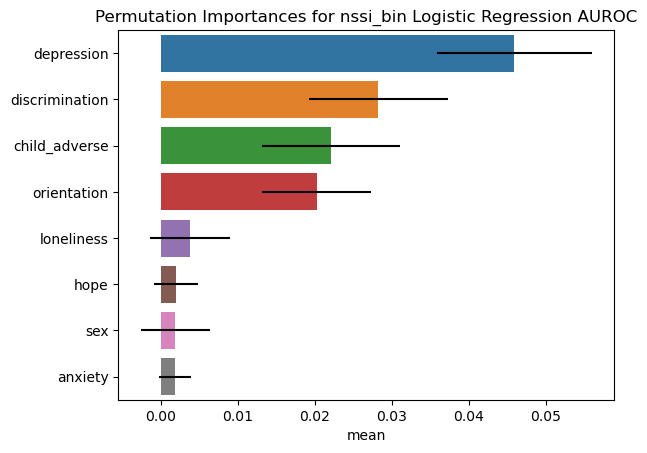

In [26]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

In [27]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [28]:
# define target
target = data_minor['nssi_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [29]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.652 +/- 0.032
The mean precision with cross-validation is: 0.873 +/- 0.015
The mean recall with cross-validation is: 0.665 +/- 0.049
The mean AUROC with cross-validation is: 0.682 +/- 0.048


                    mean       std
depression      0.050091  0.022548
sex             0.021438  0.019102
anxiety         0.020160  0.011120
discrimination  0.015269  0.014681
orientation     0.008278  0.012042
child_adverse   0.001024  0.011315
loneliness     -0.002121  0.006569
hope           -0.002675  0.003895


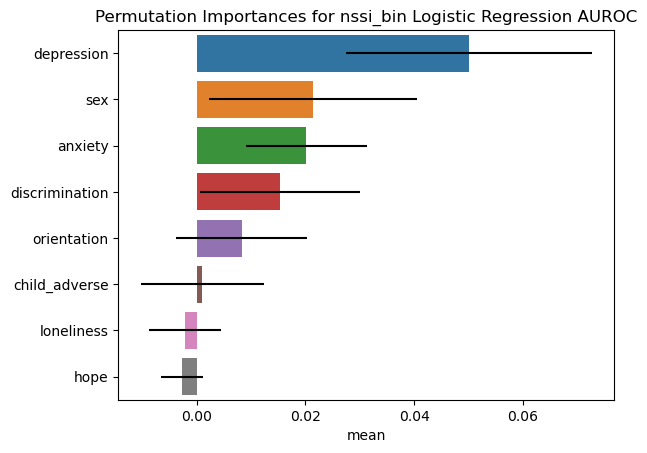

In [30]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

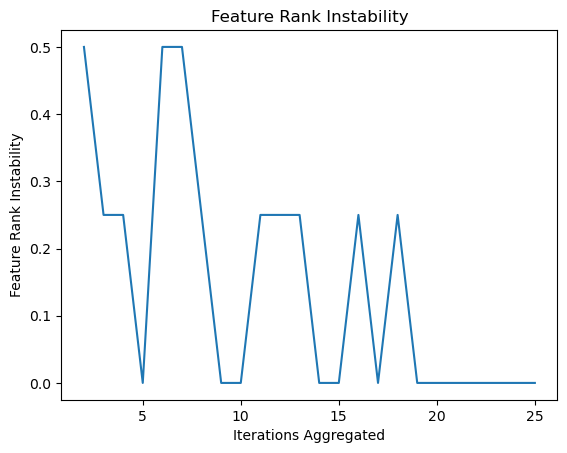

In [31]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### si_bin

#### cis

In [32]:
# define target
target = data_cis['si_bin']

# define features
features = data_cis[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [33]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [34]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [35]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.688 +/- 0.013
The mean precision with cross-validation is: 0.877 +/- 0.011
The mean recall with cross-validation is: 0.691 +/- 0.022
The mean AUROC with cross-validation is: 0.745 +/- 0.016


                    mean       std
depression      0.093077  0.021105
child_adverse   0.044517  0.009728
orientation     0.016286  0.006327
discrimination  0.002679  0.002866
loneliness      0.000203  0.002186
anxiety        -0.000050  0.002875
sex            -0.000206  0.001754
hope           -0.001614  0.002970


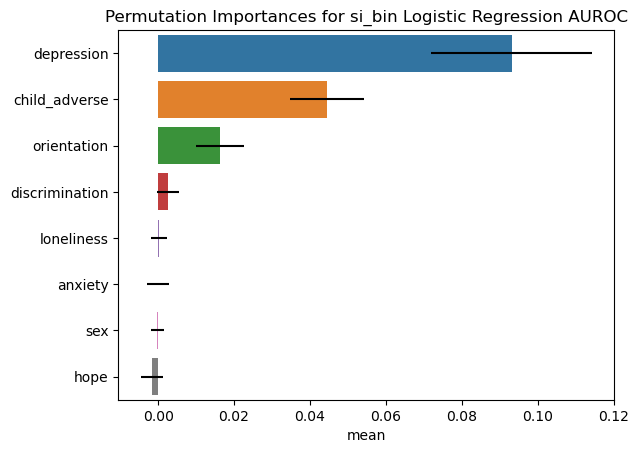

In [36]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

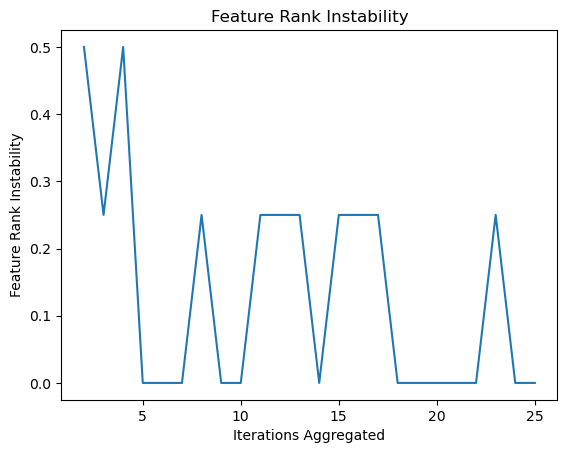

In [37]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [38]:
# define target
target = data_minor['si_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [39]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.660 +/- 0.007
The mean precision with cross-validation is: 0.923 +/- 0.024
The mean recall with cross-validation is: 0.675 +/- 0.025
The mean AUROC with cross-validation is: 0.665 +/- 0.069


                    mean       std
depression      0.072169  0.035203
anxiety         0.018307  0.014557
loneliness      0.014036  0.011785
child_adverse   0.000737  0.016091
discrimination -0.001325  0.007341
orientation    -0.001731  0.018540
sex            -0.001837  0.006450
hope           -0.002534  0.015893


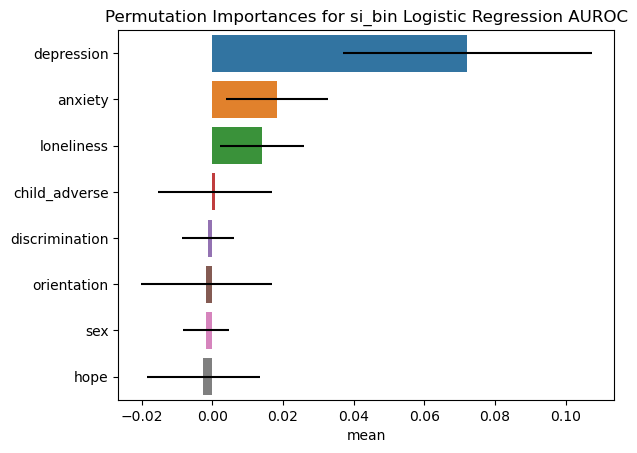

In [40]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

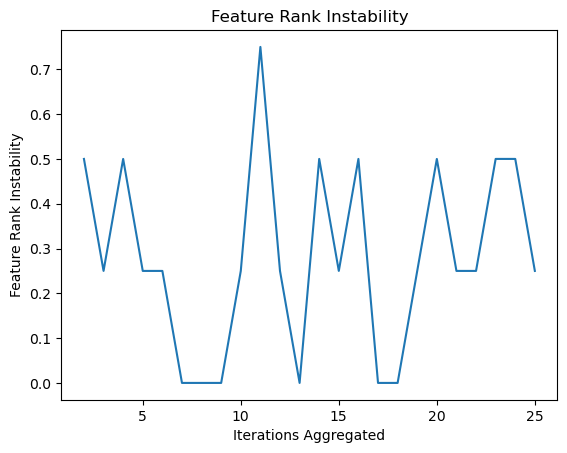

In [41]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### attempt_bin

#### cis

In [42]:
# define target
target = data_cis['attempt_bin']

# define features
features = data_cis[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [43]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [44]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [45]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.677 +/- 0.023
The mean precision with cross-validation is: 0.427 +/- 0.025
The mean recall with cross-validation is: 0.689 +/- 0.047
The mean AUROC with cross-validation is: 0.757 +/- 0.028


                    mean       std
depression      0.099813  0.019064
child_adverse   0.040422  0.009857
discrimination  0.024540  0.007742
orientation     0.015488  0.007739
hope            0.002322  0.006043
loneliness      0.000282  0.003790
anxiety        -0.000694  0.001157
sex            -0.000771  0.001152


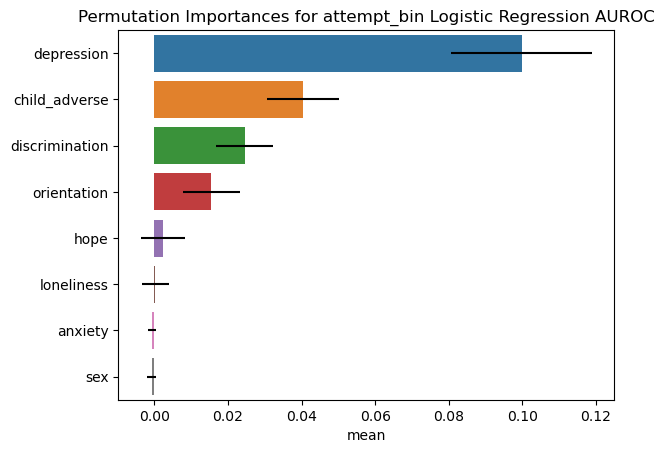

In [46]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for attempt_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

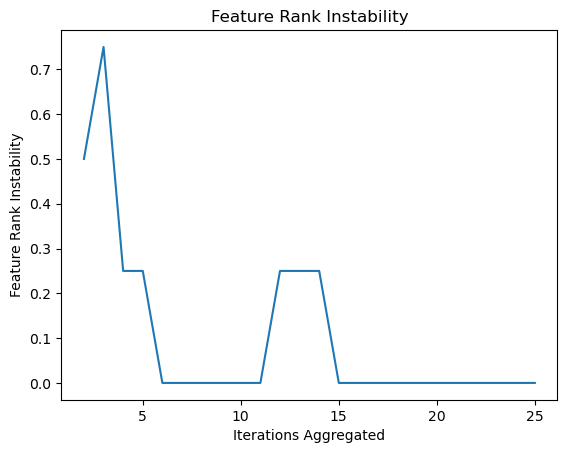

In [47]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [48]:
# define target
target = data_minor['attempt_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [49]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.675 +/- 0.026
The mean precision with cross-validation is: 0.607 +/- 0.034
The mean recall with cross-validation is: 0.677 +/- 0.010
The mean AUROC with cross-validation is: 0.734 +/- 0.024


                    mean       std
discrimination  0.087278  0.013333
depression      0.036320  0.008497
child_adverse   0.022455  0.010453
sex             0.002753  0.002417
anxiety         0.002237  0.003778
loneliness     -0.000649  0.001506
hope           -0.000733  0.002515
orientation    -0.001100  0.006806


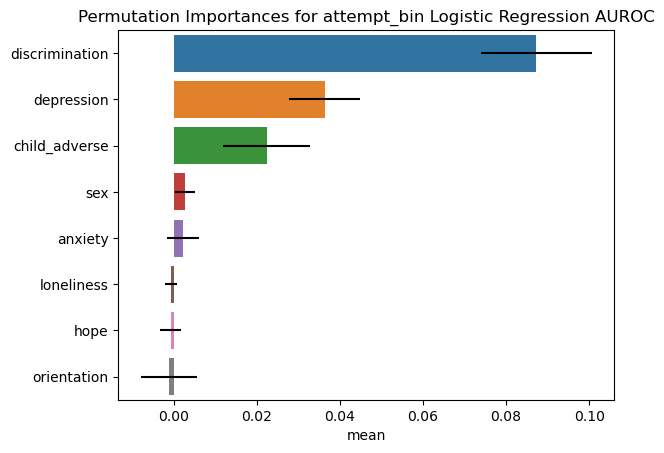

In [50]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for attempt_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

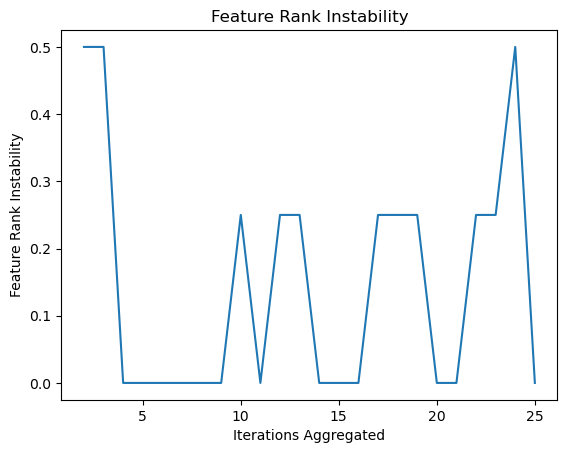

In [51]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### nssi_year

In [52]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# create subsets of data for each gender group
data_cis = nssi_year_data[nssi_year_data['gender'] != 'gender_diverse'].copy()
data_minor = nssi_year_data[nssi_year_data['gender'] == 'gender_diverse'].copy()

#### cis

In [53]:
# define target
target = data_cis['nssi_year']

# define features
features = data_cis[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = KFold(n_splits=5)

In [54]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [55]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [56]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 64.179 +/- 13.838
The mean Poisson deviance with cross-validation is: 53.968 +/- 11.687


In [57]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

                    mean       std
depression      5.221522  2.576250
anxiety         2.289183  1.541173
discrimination  1.902857  1.205276
sex             0.729509  0.353175
hope            0.620930  1.157924
orientation     0.131207  0.492972
child_adverse  -0.169051  0.431089
loneliness     -0.250169  0.373973


In [58]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [59]:
# define target
target = data_minor['nssi_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [60]:
# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 124.633 +/- 35.744
The mean Poisson deviance with cross-validation is: 122.112 +/- 34.695


In [61]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

                     mean       std
depression      23.208075  9.205190
discrimination   5.145277  3.517445
hope             2.771410  2.559810
anxiety          2.044876  1.969056
child_adverse    0.671504  1.074005
orientation      0.458393  1.296832
sex             -0.036586  1.338304
loneliness      -0.209709  1.825598


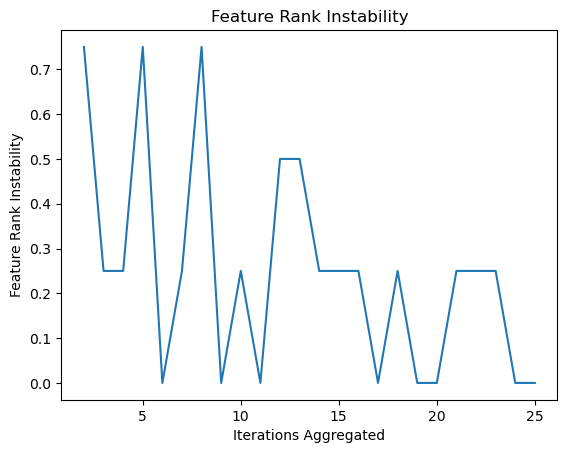

In [62]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### si_year

In [63]:
# drop records missing si_year for si_year models
si_year_data = data.dropna(subset='si_year')

# create subsets of data for each gender group
data_cis = si_year_data[si_year_data['gender'] != 'gender_diverse'].copy()
data_minor = si_year_data[si_year_data['gender'] == 'gender_diverse'].copy()

#### cis

In [64]:
# define target
target = data_cis['si_year']

# define features
features = data_cis[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = KFold(n_splits=5)

In [65]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [66]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [67]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 132.646 +/- 11.180
The mean Poisson deviance with cross-validation is: 122.073 +/- 11.912


                     mean       std
depression      31.809132  7.943011
anxiety         10.987419  3.466050
hope             3.184613  2.655148
child_adverse    2.049763  1.797412
loneliness      -0.155528  0.965255
discrimination  -0.183102  0.525134
sex             -0.207412  0.241474
orientation     -0.746564  1.042343


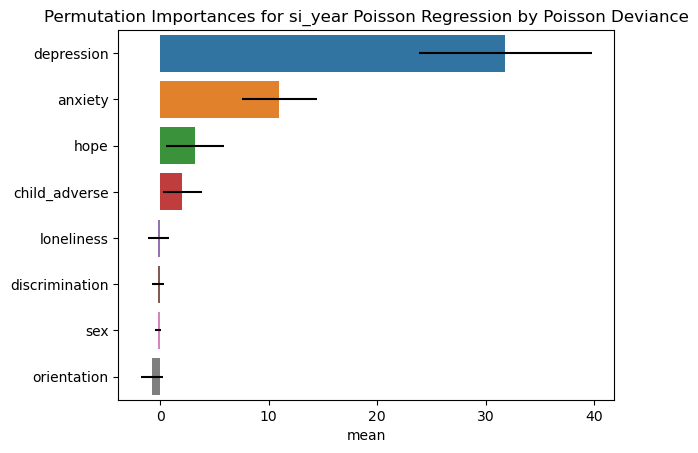

In [68]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

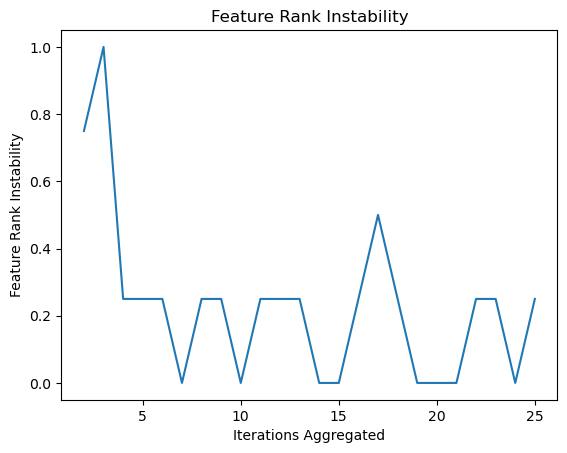

In [69]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [70]:
# define target
target = data_minor['si_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [71]:
# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 170.237 +/- 23.210
The mean Poisson deviance with cross-validation is: 168.248 +/- 24.665


In [72]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

                     mean       std
depression      22.940839  8.562932
anxiety          8.773925  6.656409
loneliness       5.096591  4.261206
discrimination   4.053060  4.066486
child_adverse    1.668198  3.726379
orientation      0.378744  2.172065
hope            -0.069505  0.721605
sex             -0.474873  0.984634


In [73]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### Summary

(described differences refer to moving from cisgender group to gender minority group unless specified)  
  
nssi_bin  
They are different.  
Discrimination dropped 2nd to 3rd  
Child dropped 3rd to 6th and no longer above 0  
Hope dropped from 6th to 8th and longer above 0  
Orientation more important in cis, sex and anxiety more important in minority  
  
si_bin  
They are different.  
Child dropped 2nd to 5th and no longer above 0  
Loneliness rose 5th to 3rd and surpassed 0  
Discrimination 0 for both  
Orientation more important in cis, anxiety more important in minority  
  
attempt_bin  
They are different.  
Depression usually 1st, but discrimination rose 3rd to 1st, well above depression  
Child dropped 2nd to 3rd, but explained by discrimination jump  
Loneliness 0 for both  
Orientation more important in cis  
  
nssi_year  
Anxiety dropped 2nd to 4th and no longer above 0  
Sex a little more important in cis  
Depression still clear 1st rank for both  
  
si_year  
They are different.  
Loneliness rose 5th (0) to 3rd  
Discrimination 0 for both  
Child surpassed 0 barely (although technically rank dropped)  
Depression and anxiety clear 1st and 2nd for both  
  
OVERALL:  
Feature importance rankings did differ between the gender identity groups.  
Discrimination, childhood adversity, and loneliness were not consistently higher in ranking for the gender minority group vs. the cisgender group across the various targets.  
Nevertheless, loneliness may be more important in the gender minority group for predicting outcomes related to suicidal ideation.  
Depression was the most important feature for all models with one notable exception.  
It was strongly overtaken by discrimination for the binary prediction of suicide attempt in the gender minority group.  
Sexual orientation was a more important feature within the cisgender group vs. the gender minority group for all binary predictions.  

## Orientation subgroup analyses

In [74]:
# create subsets of data for each orientation group
data_hetero = data[data['orientation'] == 'Heterosexual/Straight'].copy()
data_minor = data[data['orientation'] != 'Heterosexual/Straight'].copy()

In [75]:
# Levene's tests
print("Levene's test results:")
quants = ['loneliness', 'depression', 'hope', 'child_adverse', 'discrimination', 'anxiety',
         'nssi_year', 'si_year']
for i in quants:
    _, p_value = stats.levene(data_hetero[i].dropna(), data_minor[i].dropna())
    print(i, 'p value:', f'{p_value:.3f}')

Levene's test results:
loneliness p value: 0.006
depression p value: 0.000
hope p value: 0.894
child_adverse p value: 0.087
discrimination p value: 0.056
anxiety p value: 0.000
nssi_year p value: 0.000
si_year p value: 0.002


In [76]:
# Independent-samples t tests
print("Independent-samples t test results:")
quants_equal_var = ['hope', 'child_adverse', 'discrimination']
quants_unequal_var = ['loneliness', 'depression', 'anxiety', 'nssi_year', 'si_year']

for i in quants_equal_var:
    t_value, p_value = stats.ttest_ind(data_hetero[i].dropna(), data_minor[i].dropna())
    print(i, '-- heterosexual:', f'{data_hetero[i].mean():.2f}', '-- minority:', f'{data_minor[i].mean():.2f}', 
          '-- t value:', f'{t_value:.2f}', '-- p value:', f'{p_value:.3f}')

for i in quants_unequal_var:
    t_value, p_value = stats.ttest_ind(data_hetero[i].dropna(), data_minor[i].dropna(), equal_var=False)
    print(i, '-- heterosexual:', f'{data_hetero[i].mean():.2f}', '-- minority:', f'{data_minor[i].mean():.2f}', 
          '-- t value:', f'{t_value:.2f}', '-- p value:', f'{p_value:.3f}')

Independent-samples t test results:
hope -- heterosexual: 26.04 -- minority: 22.89 -- t value: 7.51 -- p value: 0.000
child_adverse -- heterosexual: 1.84 -- minority: 2.54 -- t value: -9.69 -- p value: 0.000
discrimination -- heterosexual: 26.36 -- minority: 30.74 -- t value: -8.68 -- p value: 0.000
loneliness -- heterosexual: 35.72 -- minority: 39.15 -- t value: -6.18 -- p value: 0.000
depression -- heterosexual: 12.41 -- minority: 14.69 -- t value: -10.52 -- p value: 0.000
anxiety -- heterosexual: 18.99 -- minority: 21.42 -- t value: -8.68 -- p value: 0.000
nssi_year -- heterosexual: 11.90 -- minority: 29.75 -- t value: -5.32 -- p value: 0.000
si_year -- heterosexual: 42.22 -- minority: 69.56 -- t value: -3.97 -- p value: 0.000


In [77]:
# chi square tests of independence
data['orientation_group'] = np.select([(data['orientation'] == 'Heterosexual/Straight'), 
                                       (data['orientation'] != 'Heterosexual/Straight')],
                                 ['heterosexual', 'minority'])

print('Results for chi square tests of independence')
categoricals = ['sex', 'gender', 'nssi_bin', 'si_bin', 'attempt_bin']

for i in categoricals:
    contingency = pd.crosstab(data[i], data['orientation_group'])
    print('\n', pd.crosstab(data[i], data['orientation_group'], normalize='columns'))
    
    # don't include rows with counts less than 10 in test
    chi_results = stats.chi2_contingency(contingency[(contingency['heterosexual'] >= 10) & (contingency['minority'] >= 10)])
    print(i, '-- x2:', f'{chi_results[0]:.2f}', '-- df:', f'{chi_results[2]:.2f}', 
          '-- p value:', f'{chi_results[1]:.3f}')

Results for chi square tests of independence

 orientation_group  heterosexual  minority
sex                                      
Female                 0.815261  0.898105
Male                   0.184739  0.081413
Other                  0.000000  0.010241
Prefer not to say      0.000000  0.010241
sex -- x2: 42.67 -- df: 1.00 -- p value: 0.000

 orientation_group  heterosexual  minority
gender                                   
gender_diverse         0.024096  0.445981
man_only               0.178715  0.049667
woman_only             0.797189  0.504352
gender -- x2: 343.48 -- df: 2.00 -- p value: 0.000

 orientation_group  heterosexual  minority
nssi_bin                                 
0.0                    0.534137  0.272401
1.0                    0.465863  0.727599
nssi_bin -- x2: 122.61 -- df: 1.00 -- p value: 0.000

 orientation_group  heterosexual  minority
si_bin                                   
0                      0.353414  0.145929
1                      0.646586  0.85407

### nssi_bin

#### heterosexual

In [78]:
# define target
target = data_hetero['nssi_bin']

# define features
features = data_hetero[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [79]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [80]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [81]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.641 +/- 0.032
The mean precision with cross-validation is: 0.617 +/- 0.039
The mean recall with cross-validation is: 0.604 +/- 0.043
The mean AUROC with cross-validation is: 0.714 +/- 0.048


                    mean       std
depression      0.058836  0.027922
discrimination  0.050015  0.018124
child_adverse   0.006837  0.012182
loneliness      0.001217  0.007766
sex            -0.001051  0.004715
anxiety        -0.001129  0.004117
gender         -0.001726  0.005554
hope           -0.003185  0.006556


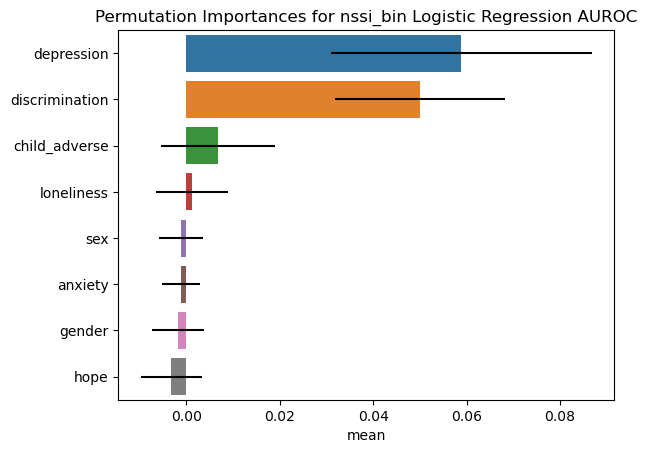

In [82]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

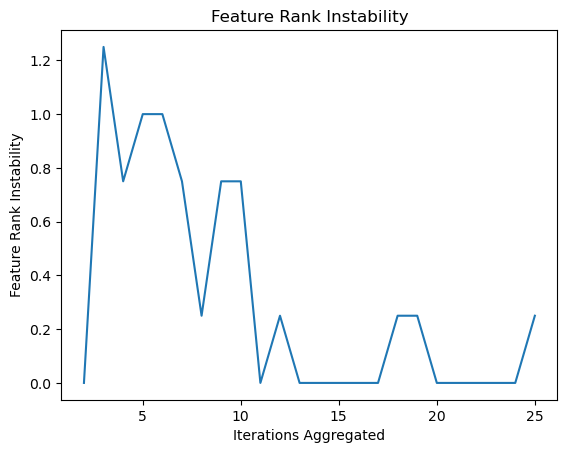

In [83]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [84]:
# define target
target = data_minor['nssi_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [85]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.665 +/- 0.017
The mean precision with cross-validation is: 0.843 +/- 0.010
The mean recall with cross-validation is: 0.663 +/- 0.026
The mean AUROC with cross-validation is: 0.720 +/- 0.018


                    mean       std
depression      0.051460  0.010005
discrimination  0.020490  0.004530
child_adverse   0.019557  0.006406
gender          0.019102  0.007755
sex             0.015219  0.009811
anxiety         0.007318  0.003252
hope            0.000897  0.003243
loneliness     -0.000347  0.001111


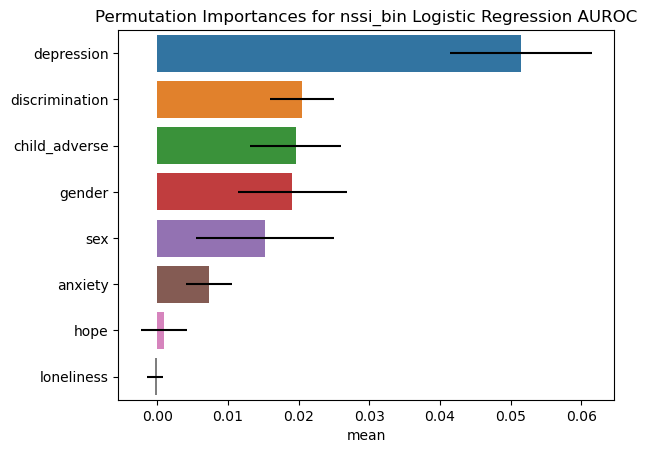

In [86]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

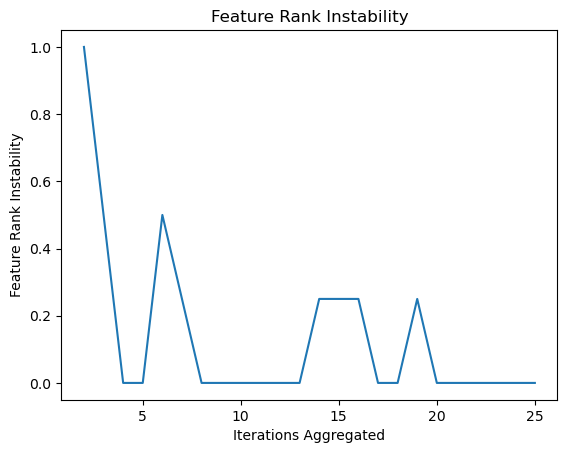

In [87]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### si_bin

#### heterosexual

In [88]:
# define target
target = data_hetero['si_bin']

# define features
features = data_hetero[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [89]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [90]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [91]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.685 +/- 0.044
The mean precision with cross-validation is: 0.818 +/- 0.058
The mean recall with cross-validation is: 0.661 +/- 0.028
The mean AUROC with cross-validation is: 0.763 +/- 0.040


                    mean       std
depression      0.094125  0.033487
child_adverse   0.054870  0.015905
discrimination  0.015598  0.009094
hope            0.001479  0.005832
anxiety         0.001066  0.006115
loneliness      0.000363  0.005162
gender         -0.000186  0.003306
sex            -0.000511  0.003377


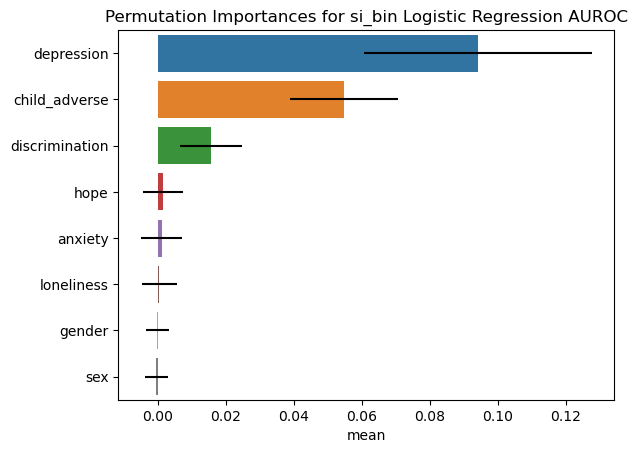

In [92]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

In [93]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [94]:
# define target
target = data_minor['si_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [95]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.668 +/- 0.011
The mean precision with cross-validation is: 0.918 +/- 0.015
The mean recall with cross-validation is: 0.672 +/- 0.009
The mean AUROC with cross-validation is: 0.703 +/- 0.046


                    mean       std
depression      0.117196  0.019689
child_adverse   0.037685  0.010286
anxiety         0.005383  0.003898
gender          0.004900  0.004465
loneliness      0.001803  0.003533
sex             0.000076  0.003100
hope           -0.001991  0.003764
discrimination -0.002038  0.002630


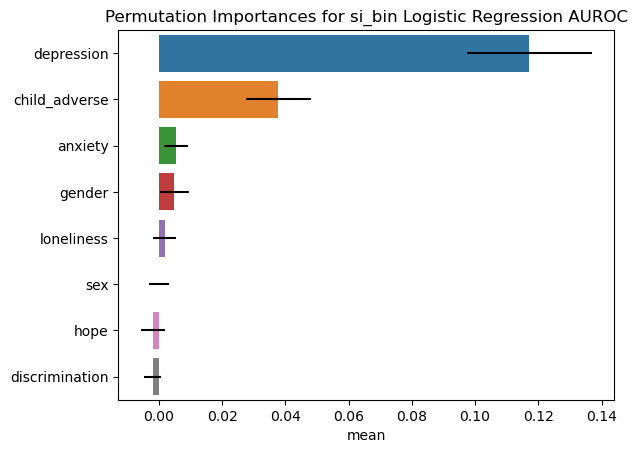

In [96]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

In [97]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### attempt_bin

#### heterosexual

In [98]:
# define target
target = data_hetero['attempt_bin']

# define features
features = data_hetero[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [99]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [100]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [101]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.715 +/- 0.017
The mean precision with cross-validation is: 0.356 +/- 0.037
The mean recall with cross-validation is: 0.723 +/- 0.166
The mean AUROC with cross-validation is: 0.794 +/- 0.073


                    mean       std
depression      0.051854  0.020333
child_adverse   0.045877  0.011660
discrimination  0.036992  0.023101
loneliness      0.003626  0.009393
gender         -0.000069  0.003075
hope           -0.000101  0.003831
sex            -0.000403  0.001922
anxiety        -0.001661  0.003140


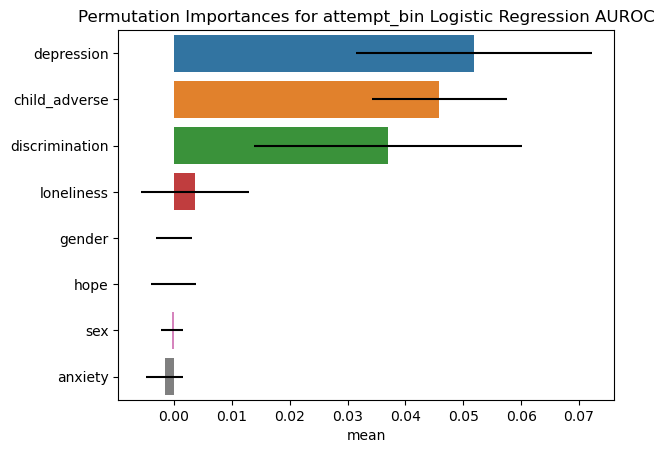

In [102]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for attempt_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

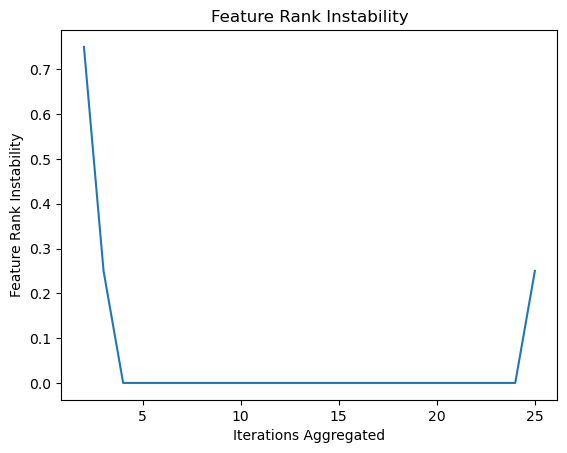

In [103]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [104]:
# define target
target = data_minor['attempt_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [105]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.673 +/- 0.020
The mean precision with cross-validation is: 0.531 +/- 0.023
The mean recall with cross-validation is: 0.682 +/- 0.018
The mean AUROC with cross-validation is: 0.738 +/- 0.021


                    mean       std
depression      0.069846  0.011905
discrimination  0.050203  0.007538
child_adverse   0.034329  0.005456
hope            0.003557  0.002728
gender          0.002433  0.003367
sex             0.000949  0.001742
anxiety         0.000611  0.001466
loneliness     -0.000736  0.001194


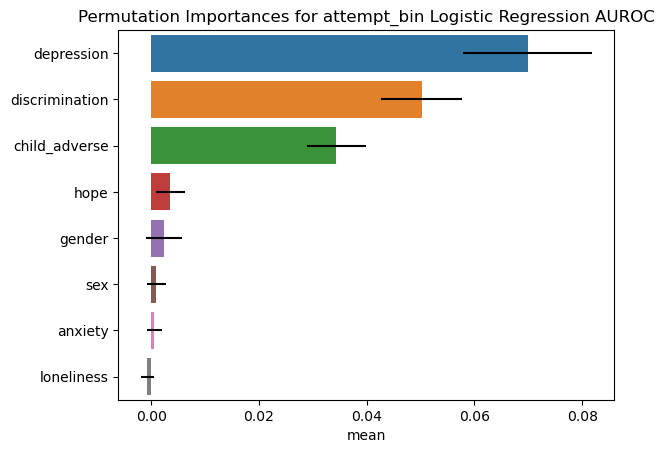

In [106]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for attempt_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

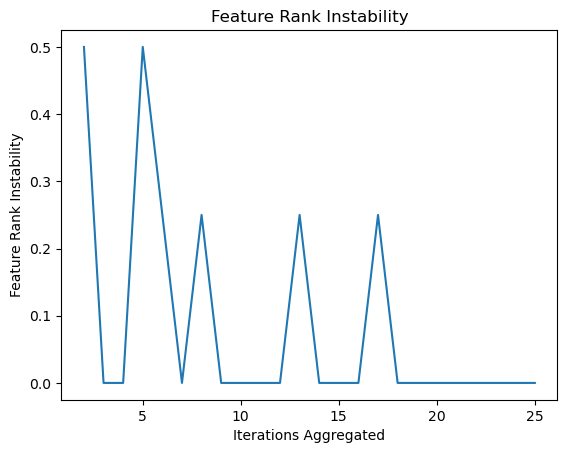

In [107]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### nssi_year

In [108]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# create subsets of data for each orientation group
data_hetero = nssi_year_data[nssi_year_data['orientation'] == 'Heterosexual/Straight'].copy()
data_minor = nssi_year_data[nssi_year_data['orientation'] != 'Heterosexual/Straight'].copy()

#### heterosexual

In [109]:
# define target
target = data_hetero['nssi_year']

# define features
features = data_hetero[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = KFold(n_splits=5)

In [110]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [111]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [112]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 45.800 +/- 20.498
The mean Poisson deviance with cross-validation is: 40.339 +/- 15.593


                    mean       std
depression      5.071794  5.313041
discrimination  4.572266  4.580612
hope            0.871255  2.643262
sex             0.327760  0.411912
anxiety         0.270834  0.894949
gender          0.196583  0.372330
loneliness      0.014818  0.724617
child_adverse  -0.055259  1.101622


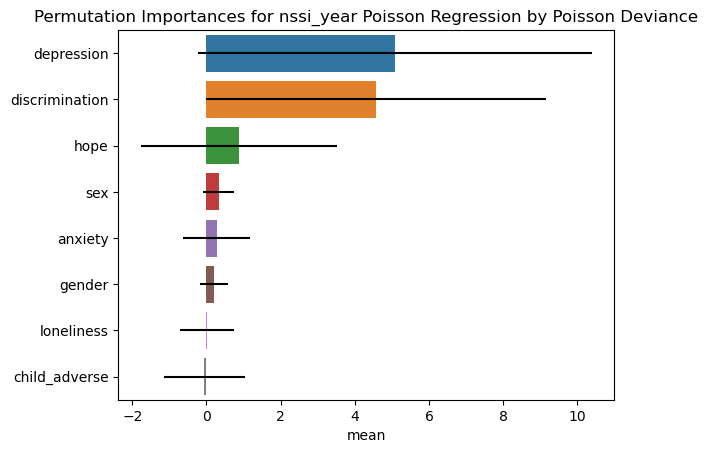

In [113]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

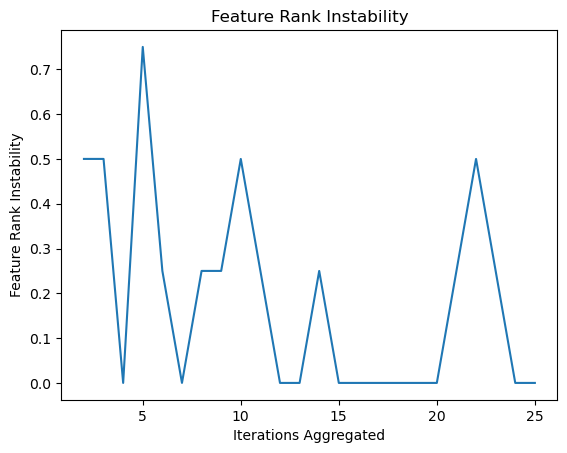

In [114]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [115]:
# define target
target = data_minor['nssi_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [116]:
# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 98.491 +/- 25.961
The mean Poisson deviance with cross-validation is: 88.275 +/- 24.825


                     mean       std
depression      13.115325  4.553889
anxiety          3.272080  2.232648
discrimination   3.210125  2.100635
gender           3.002330  1.687638
sex              0.305359  0.764655
child_adverse   -0.003974  1.168612
loneliness      -0.056886  0.635060
hope            -0.181231  0.664163


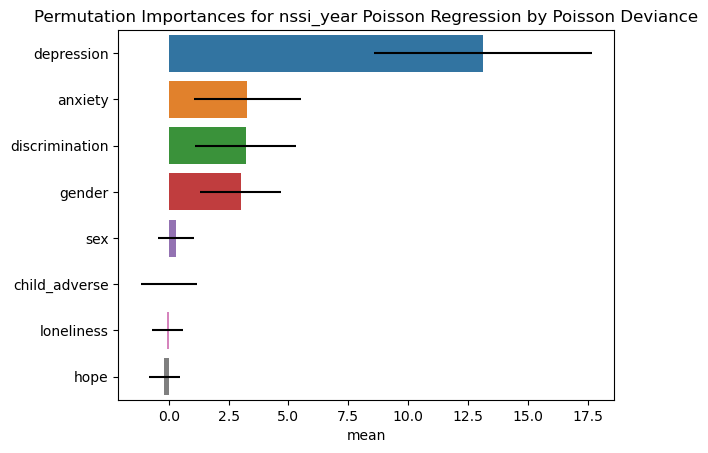

In [117]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

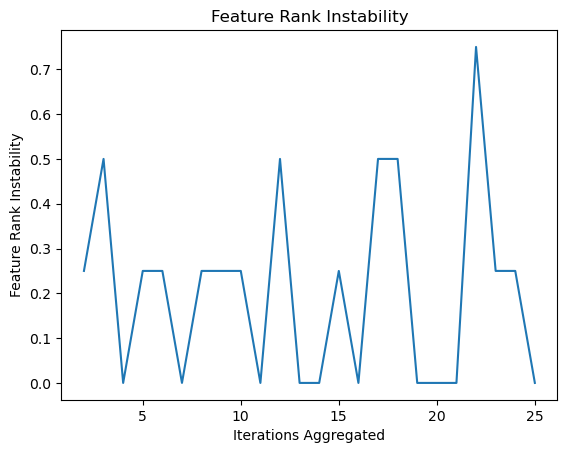

In [118]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### si_year

In [119]:
# drop records missing si_year for si_year models
si_year_data = data.dropna(subset='si_year')

# create subsets of data for each orientation group
data_hetero = si_year_data[si_year_data['orientation'] == 'Heterosexual/Straight'].copy()
data_minor = si_year_data[si_year_data['orientation'] != 'Heterosexual/Straight'].copy()

#### heterosexual

In [120]:
# define target
target = data_hetero['si_year']

# define features
features = data_hetero[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = KFold(n_splits=5)

In [121]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [122]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [123]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 113.270 +/- 36.343
The mean Poisson deviance with cross-validation is: 103.120 +/- 30.044


In [124]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

                     mean        std
depression      32.755600  15.131641
anxiety         20.293400  11.015799
loneliness       5.996995   6.164969
hope             5.264089   4.902701
child_adverse    4.270581   5.209455
gender          -0.002099   1.134093
sex             -0.490526   1.237319
discrimination  -1.033044   1.980200


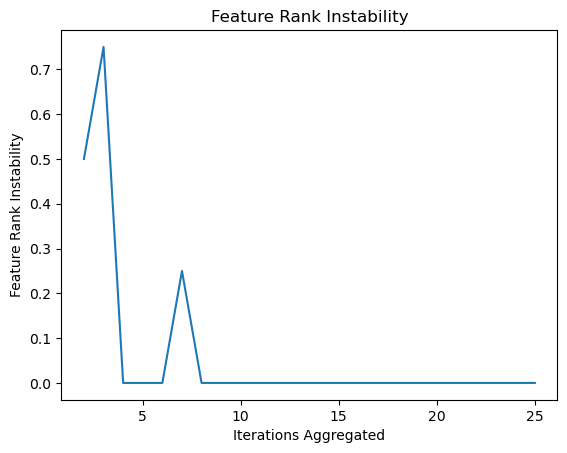

In [125]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [126]:
# define target
target = data_minor['si_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [127]:
# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 154.357 +/- 18.206
The mean Poisson deviance with cross-validation is: 148.914 +/- 20.113


                     mean       std
depression      25.457426  7.380114
anxiety          7.817732  3.893909
child_adverse    1.662829  1.531265
loneliness       1.236084  1.393757
discrimination   0.916035  1.460848
hope            -0.089710  0.999463
sex             -0.137474  0.265623
gender          -0.175492  0.656246


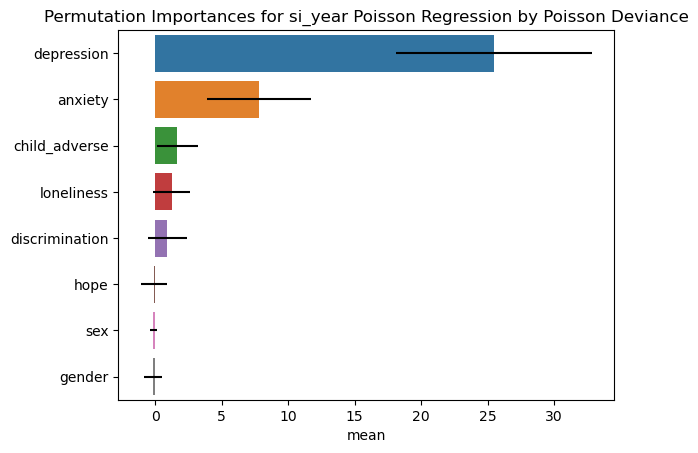

In [128]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

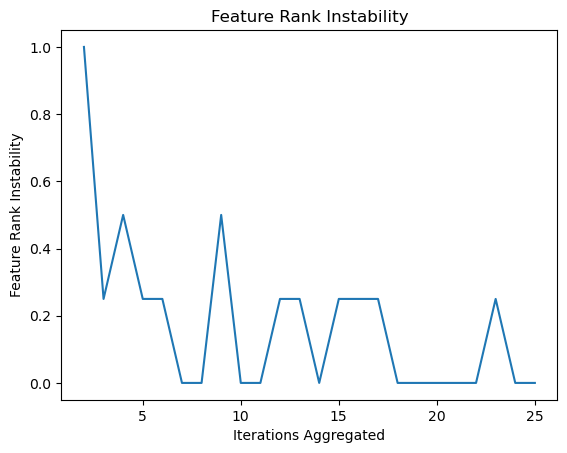

In [129]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### Summary

(described differences refer to moving from heterosexual group to orientation minority group unless specified)  
  
nssi_bin  
They are different.  
Discrimination dropped 2nd to 4th  
Gender and sex more important in minority  
  
si_bin  
They are different.  
Discrimination dropped 3rd to 8th and no longer above 0  
Gender possibly more important in minority  
  
attempt_bin  
They are different.  
Child 2nd in hetero and 3rd in minority, while discrimination 3rd in hetero and 2nd in minority   
  
nssi_year  
Anxiety rose 5th (0) to 2nd  
Gender maybe more important in minority  
  
si_year  
Not much difference.  
Child and discrimination possibly more important in minority    
  
OVERALL:  
Feature importance rankings did differ between the orientation groups, more so for binary predictions.  
Discrimination, childhood adversity, and loneliness were not consistently higher in ranking for the sexual minority group vs. the heterosexual group across the various targets.   
Depression was the most important feature for all models.  
Not many other consistent or strong findings to note.